<a href="https://colab.research.google.com/github/jhev/coin_simulation/blob/main/oct25_SameMining1_FixedQmark_coin_two_20DayNoFloorSameMining1_Competition_Asset_Valuation_with_WoM_model3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Changes**

- mining cost the same, then current price


## **Findings:**

- no floor and small network, price tanks. Positive results at 1000 nodes (and even then sometimes the price tanks), tried up to 900.
- will drop nodes and widen stand dev of valuations.

- varying look-back window (7 day,14 day, forever):
- if second coin gets started too late price either does not change or stays small. Coin 1 becomes too attractive. The quicker coin 2 is launched the "better" it does, but coin 1 tends to win if launched first.
- if supply of coin 2 doesn't change, it spikes and dies and coin 1 price path doesn't change much.
- at 50 days price of coin 2 stays at initial price...




-----------------------
-----------------------
# Starting the simulation
-----------------------

Installing an external package, robostats, to aid with weighted median calcuations

In [ ]:
!pip install robustats
!pip install wbdata
!pip install statsmodels

In [ ]:
# Loading required packages

import pandas as pd
import seaborn as sns; sns.set() # pretty plotting
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import random
import robustats
import networkx as nx
import scipy.stats as ss
import statsmodels.api as sm
import statistics
from scipy import stats, optimize
from scipy.optimize import curve_fit
import wbdata as wb
from scipy.integrate import quad
from matplotlib.path import Path
from matplotlib.patches import PathPatch
from scipy.optimize import curve_fit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

#For noise
from random import seed
from pandas import Series
from pandas.plotting import autocorrelation_plot
from random import gauss

plt.style.use('seaborn')
%matplotlib inline
np.set_printoptions(suppress=True)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
jhevon = [1,3,0,5,1]

jhevon_noise = np.random.uniform(0.0, 1.0, len(jhevon))

new_jhevon = jhevon + jhevon_noise

print('jhevon is: ', jhevon)
print('noise is: ', jhevon_noise)
print('jhevon with noise is: ', new_jhevon)

jhevon is:  [1, 3, 0, 5, 1]
noise is:  [0.96444462 0.34104828 0.6436261  0.39851578 0.71496177]
jhevon with noise is:  [1.96444462 3.34104828 0.6436261  5.39851578 1.71496177]


We first begin by defining or mining cost function. We begin by assuming this to be polynomial in nature, beginning with some constant. We use the poly1d function from numpy.

In [ ]:
# mining_cost = np.poly1d([1]) #setting mining cost for 1 coin to be 1. We assume cost correlates with difficulty

# mining_cost2 = np.poly1d([1])

mining_cost = 1

mining_cost2 = 0.25

Setting up variables and values and important arrays

In [ ]:
# Set up global parameters

# To set up graph
n = 202 # set network size, TWO nodes will operate as exchanges
#e = np.random.choice(np.linspace(0.001, 0.01, 100))
q = 0.015 #q=0.001 #(1+e) * (np.log(n) / n)
# print('e: {},\nq: {}\nnq: {} '.format(e, q, n * q))
smp = 0.01*n # set seed size -- we will assume there is one exchange node

# To set length of simulation
days = 100 # set number of days for simulation, 730 days = 2 years, 1095 days = three years
day2 = 5 # the day the second coin hits the market

# look_back_window = 7 #how far back nodes look to make decision -- put in the simulation

trials = 50 #Number of simulations to take the mean of

# Initial coin count on network
vol = 1000 # set initial number of coins on the network, held by the exchange
vol2 = 1000

cap = 2000
cap2 = 2000
half = 6 #set halving period
half2 = 6

# Initial price
# initial_price = mining_cost(0) #price initially set to mining cost 
# initial_price2 = mining_cost2(0)

initial_price = mining_cost
initial_price2 = mining_cost2

# Probability of sharing
prob = 0.03 # Probability an exposed node will share if they like the asset
no_prob = prob/3 # Probability of sharing if a node does NOT like the asset. 

prob2 = 0.03
no_prob2 = prob2/3

# To set up income of nodes on network
max_tol = 0.10 # Maximum percentage of income willing to invest
min_tol = 0.001
median_income = 30000
std_dev_income = 6000

# min_hold = 0.25
# max_hold = 1

## Creating graph
$n$ nodes and Poission degree distribution with rate $q$

In [ ]:
# Create random graph with Poisson degree distribution, lambda = (n - 1)*q

g = nx.erdos_renyi_graph(n,q)

## Defining an exchange node

In [ ]:
# Setting node 0 and 1 to be the exchanges

exchange = [0]
exchange2 = [1]

print("The first exchange node is: ", exchange)
print("The second exchange node is: ", exchange2)

# The exchange starts out as the only coin holder. It sells to the network
# and then nodes will be able to buy and sell via the exchange node.
# Buyers buy from the exchange, and sellers sell to the exchange.

The first exchange node is:  [0]
The second exchange node is:  [1]


### Functions for analyzing the graph and its metadata

In [ ]:
# List nodes with their neighbors--Optional

def get_neighbors(g):
    neigh_dict = {}
    for i in range(n):
        neigh_dict[i] = []
        for nn in g.neighbors(i):
            neigh_dict[i].append(nn)
    return neigh_dict

In [ ]:
#get_neighbors(g)

In [ ]:
# For debugging, track the data for nodes in graph--Optional

def get_metadata(g):
    [print('N: {} {}'.format(i, g.nodes[i])) for i in range(n)]

In [ ]:
# get_metadata(g)

## Setting up initial coin distribution on the graph

In [ ]:
# Setting up initial coin distribution over the network. Only the exchange has coins in the beginning

# Everyone has 0 coins at first
coin_count = np.array([0.0] * n)
coin_count2 = np.array([0.0] * n)

# Give the exchange all the coins
coin_count[exchange] = vol
initial_coin_count = coin_count

coin_count2[exchange2] = vol2
initial_coin_count2 = coin_count2

#print("The initial coin count across the network is: \n \n", coin_count)

In [ ]:
print('coin count 1: ',coin_count,'\n')
print('coin count 2: ',coin_count2)

coin count 1:  [1000.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.

## Setting up income for nodes on the network

Assigning income values across the network. And deciding on how much discretionary income each node is willing to spend. 

In [ ]:
# Assingning incomes

income = np.array(abs(np.random.normal(median_income, std_dev_income, n)))

#print("The income of each node is: \n \n",income)

In [ ]:
# Assigning discretionary investing income / and income willing to spend on coin

investing_income = np.array([0.0] * n)
investing_coin_income = np.array([0.0]*n)



for i in range(n):
  investing_income[i] = (random.uniform(min_tol,max_tol))*income[i]
  investing_coin_income = investing_income
  #investing_coin_income[i]=random.uniform(0,1)*investing_income[i]

initial_investing_coin_income = investing_coin_income

#print("Each node's investing income is: \n",investing_income)
#print("\n \n")
#print("Each node's spending limit for coins is: \n", investing_coin_income)

## Setting up coin valuation for nodes on the network

In [ ]:
# Setting initial coin valuation on the network

coin_value = coin_count.copy().astype(np.float16)
coin_value[coin_value == 0.0] = np.random.normal(loc=initial_price, scale=initial_price/2, size=(coin_value == 0.0).sum())
coin_value[exchange] = 1
coin_value = [0 if i < 0 else i for i in coin_value]

initial_coin_value = coin_value

coin_valuation = coin_value
initial_coin_valuation = coin_valuation
############
coin_value2 = coin_count2.copy().astype(np.float16)
coin_value2[coin_value2 == 0.0] = np.random.normal(loc=initial_price2, scale=initial_price/2, size=(coin_value2 == 0.0).sum())
coin_value2[exchange2] = 1
coin_value2 = [0 if i < 0 else i for i in coin_value2]

initial_coin_value2 = coin_value2

coin_valuation2 = coin_value2
initial_coin_valuation2 = coin_valuation2

print("The initial valuation of coin one of each node is: \n", coin_value)
print("The initial valuation of coin two of each node is: \n", coin_value2)

The initial valuation of coin one of each node is: 
 [1.0, 1.014, 1.268, 1.41, 1.442, 1.878, 0.694, 0.3596, 0.4856, 0.7876, 0.611, 1.154, 1.922, 0.953, 1.849, 1.29, 0.5938, 0.519, 1.523, 0.4873, 1.698, 0.8335, 0, 1.316, 0.07806, 0.595, 1.206, 0.3704, 0.5176, 1.177, 0.8545, 0.7437, 0.718, 0.773, 1.082, 1.014, 0.978, 0.3179, 1.601, 0.7324, 0.07947, 0.4358, 0.2625, 1.985, 1.381, 1.043, 0.618, 1.405, 0.6455, 0.6074, 1.483, 0.923, 1.61, 0.326, 0.7046, 0.5366, 1.799, 0.4268, 0, 1.91, 0.881, 0.2169, 0.463, 1.055, 1.602, 0.3223, 0.8594, 1.582, 0.6445, 0.8457, 0.2505, 0.5137, 1.081, 0, 1.318, 1.146, 1.9, 0, 1.347, 0.739, 1.233, 0.4949, 0.6353, 0.605, 1.902, 1.152, 0.497, 0, 1.607, 2.09, 1.318, 0.678, 1.965, 1.746, 1.38, 0.87, 1.122, 1.149, 1.345, 2.064, 1.927, 1.061, 1.283, 1.806, 1.384, 1.255, 0.973, 0.738, 0.993, 1.353, 0.8457, 0.5537, 0.5674, 0.441, 1.73, 1.344, 1.858, 1.641, 0.8857, 1.136, 0.4885, 1.2295, 1.392, 1.502, 1.233, 1.169, 0.8945, 1.65, 1.541, 1.769, 1.195, 0.8066, 0.829, 0.6724, 

In [ ]:
max(coin_value2)

1.873

In [ ]:
max(coin_value)

2.09

###Defining the initial exposed to get initial pricing

In [ ]:
initial_exposed = np.array([ne for ne in g.neighbors(0)])
exposed = initial_exposed
initial_exposed_valuation = np.array([initial_coin_value[i] for i in exposed])
initial_exposed_investing_income = np.array([investing_coin_income[i] for i in exposed])

#######
initial_exposed2 = np.array([ne for ne in g.neighbors(1)])
exposed2 = initial_exposed2
initial_exposed_valuation2 = np.array([initial_coin_value2[i] for i in exposed2])
initial_exposed_investing_income2 = np.array([investing_coin_income[i] for i in exposed2])

# print("The nodes initially aware of the coin are: \n",exposed)
# print("\n")
# print("The number of nodes that are initially asware of the coin are: ",len(exposed))
# print("\n")
# print("The coin valuations of the initially aware nodes are: \n",initial_exposed_valuation)
# print("\n")
# print("The coin investing incomes of the initially aware nodes are: \n",initial_exposed_investing_income)

In [ ]:
# Find the weighted median of initial coin valuation of entire network

wmedian_coin_value = robustats.weighted_median(initial_exposed_valuation, initial_exposed_investing_income) # robustats.weighted_median(array, weights)

wmedian_coin_value2 = robustats.weighted_median(initial_exposed_valuation2, initial_exposed_investing_income2)
#print("The initial weighted median coin valuation of aware nodes is: ", wmedian_coin_value)


In [ ]:
print('The wmedian coin value for coin one is, ',wmedian_coin_value)
print('The wmedian coin value for coin two is, ',wmedian_coin_value2)

The wmedian coin value for coin one is,  0.7021484375
The wmedian coin value for coin two is,  0.029083251953125


We will set the initial price to be: $$\text{initial sale price} = \max \left \{ \text{initial price}, \begin{matrix} \text{weighted median} \\ \text{valuation of the} \\ \text{network} \end{matrix} \right \}$$

Where the initial price is mining cost, the the "network" here is the exposed network.

In [ ]:
# Setting sale price, day 0

initial_sale_price = max(initial_price,wmedian_coin_value)
new_sale_price = initial_sale_price 

initial_sale_price2 = max(initial_price2,wmedian_coin_value2)
new_sale_price2 = initial_sale_price2 

#print("Thus, the initial sale price is: ", initial_sale_price)

In [ ]:
initial_sale_price

1

In [ ]:
initial_sale_price2

0.25

In [ ]:
# Initial perceived RoR of coin

initial_ror_coin_value = (initial_sale_price - initial_price)/(initial_price)
ror_coin = np.array([initial_ror_coin_value])
initial_ror_coin = ror_coin

####
initial_ror_coin_value2 = (initial_sale_price2 - initial_price2)/(initial_price2)
ror_coin2 = np.array([initial_ror_coin_value2])
initial_ror_coin2 = ror_coin2

#print("The initial RoR for the coin is: ", initial_ror_coin)

In [ ]:
moving_averages = initial_ror_coin

moving_averages2 = initial_ror_coin2
#print("The running average RoR of the coin on day 0 is: ", moving_averages)

In [ ]:
# Calculate long term running average (since inception)

def Average(ror_coin):
    return sum(ror_coin) / len(ror_coin)

## Simulation Part 1: Initialize graph

- create a graph
- set up the initially exposed with probability of sharing, etc. 
- set up initial coin valuations



In [ ]:
# Initialize graph--Set initial random valuation, 0<= val <=1, set initial infected (buyers),
#    set initial probability of sharing, set initial exposure (awareness of product),
#    set initial susceptibility ('susceptible = not aware of product')
#    Susceptible, exposed, infected measure on 0 ("no") or 1 ("yes") scale

def initialize_graph(new_sale_price,new_sale_price2, initial_coin_valuation, initial_coin_value2, prob, prob2, keep_val=True):

    g = nx.erdos_renyi_graph(n,q)

    exposed = [ne for ne in g.neighbors(0)]
    exposed2 = [ne for ne in g.neighbors(1)]

    for i in range(n):
        if keep_val:
            g.nodes[i]['valuation'] = initial_coin_valuation[i] #Assign valuation
            g.nodes[i]['valuation2'] = initial_coin_valuation2[i]
            
        g.nodes[i]['prob'] = prob if g.nodes[i]['valuation'] > new_sale_price else no_prob #Assign prob of
                                                                                                #sharing based on
                                                                                                #valuation
        g.nodes[i]['prob2'] = prob2 if g.nodes[i]['valuation2'] > new_sale_price2 else no_prob2 #Assign prob of
                                                                                        #sharing based on
                                                                                        #valuation
        g.nodes[i]['infected'] = 0 #Initially, infected set to "no"
        g.nodes[i]['infected2'] = 0

        if i in exposed:
            g.nodes[i]['exposed'] = 1 #Define criteria for being in exposed set
            g.nodes[i]['susceptible'] = 0
        if i in exposed2:
            g.nodes[i]['exposed2'] = 1
            g.nodes[i]['susceptible2'] = 0
        else:
            g.nodes[i]['exposed'] = 0
            g.nodes[i]['exposed2'] = 0
            g.nodes[i]['susceptible'] = 1
            g.nodes[i]['susceptible2'] = 1

    return g

## Simulation Part 2: Setting up the WoM model

- set up information spreading mechanism based on valuation

In [ ]:
# REVIEW

# New simulation algorithm, runs faster than the last version and uses less data.
# It is a function of the graph and the prob of sharing

def simulation(g, new_sale_price, new_sale_price2):
    for node, edge in g.nodes.items():
      if ('exposed' in edge) and (edge['exposed'] == 1):
          if edge['valuation'] > new_sale_price:
              g.nodes[node]['infected'] = 1 #First for loop, if exposed and valuation > pr, 
                                            # set to "infected"
      if ('exposed2' in edge) and (edge['exposed2'] == 1):
          if edge['valuation2'] > new_sale_price2:
              g.nodes[node]['infected2'] = 1 #First for loop, if exposed and valuation > pr, 
                                            # set to "infected"

          neighbors = [ne for ne in g.neighbors(node)] #Look at neighbors of infected node

          for neigh in neighbors:
            if node == 0:
              g.nodes[node]['exposed'] = 1
            if node == 1:
              g.nodes[node]['exposed2'] = 1
            else:
              if ('prob' in edge) and (edge['prob'] > np.random.uniform()): #Decide if node shares with each neighbor
                  g.nodes[neigh]['susceptible'] = 0 #If shared, remove neighbor from susceptible
                  g.nodes[neigh]['exposed'] = 1     #and change to "exposed"

              if ('prob2' in edge) and (edge['prob2'] > np.random.uniform()): #Decide if node shares with each neighbor
                  g.nodes[neigh]['susceptible2'] = 0 #If shared, remove neighbor from susceptible
                  g.nodes[neigh]['exposed2'] = 1     #and change to "exposed"
                  
                  #Then go back to first for loop and repeat for each node
    return g

Instantiating variables to be used in simulation part 3

In [ ]:
  sale_price = [initial_sale_price]*days
  new_sale_price = initial_sale_price
  rmean_coin_value = initial_ror_coin
  vol = 1000

  sale_price2 = [initial_sale_price2]*days
  new_sale_price2 = initial_sale_price2
  rmean_coin_value2 = initial_ror_coin2
  vol2 = 1000

  buyers = []
  sellers = []

  buyers2 = []
  sellers2 = []

  buyer_valuation = []
  buyer_investing_income = []
  buyable_coins = [0 for i in range(n)]
  buyers_each_day = []

  buyer_valuation2 = []
  buyer_investing_income2 = []
  buyable_coins2 = [0 for i in range(n)]
  buyers_each_day2 = []

  sellable_coins = [0 for i in range(n)]
  sellable_coins[exchange[0]] = coin_count[exchange[0]]
  coin_valuation = initial_coin_value
  ror_coin = np.array([initial_ror_coin]*days) #Track coin RoR
  moving_averages = initial_ror_coin #Track moving average of the coin RoR esch day

  sellable_coins2 = [0 for i in range(n)]
  sellable_coins[exchange2[0]] = coin_count[exchange2[0]]
  coin_valuation2 = initial_coin_value2
  ror_coin2 = np.array([initial_ror_coin2]*days) #Track coin RoR
  moving_averages2 = initial_ror_coin2 #Track moving average of the coin RoR esch day

  total_infected = [0, 0]
  total_infected2 = [0, 0]
    
  exposed = [ne for ne in g.neighbors(0)] #list(np.random.choice(range(1,n), smp, replace=False)) #choose seed randomly, set seed "exposed" 
  susceptible = set(range(n)) - set(exposed) #Everyone not exposed is "susceptible"

  exposed2 = [ne for ne in g.neighbors(1)] #list(np.random.choice(range(1,n), smp, replace=False)) #choose seed randomly, set seed "exposed" 
  susceptible2 = set(range(n)) - set(exposed2) #Everyone not exposed is "susceptible"

  wmedian_lst = []
  wmedian_lst2 = []

## Simulation Part 3: Coin Pricing Model

- number of nodes, number of days, probability of sharing, having window, look-back window chosen earlier
- variable vs non-variable income chosen below

In [ ]:
# We now define the simulation for coin exchange on the network.
# Short-term investing

def coin_price(prob,prob2,smp,coin_count,coin_count2,initial_sale_price,initial_sale_price2,investing_coin_income,ror_coin, ror_coin2,
               coin_valuation,coin_valuation2,cap,cap2,half,half2):
  coin_count = coin_count.copy()
  coin_count2 = coin_count2.copy()
  investing_coin_income = investing_coin_income.copy()
  coin_valuation = coin_valuation.copy()
  coin_valuation2 = coin_valuation2.copy()
  ror_coin = ror_coin.copy()
  ror_coin2 = ror_coin2.copy()



  # Setting initial values
  sale_price = [0.000001]*days #array of zeros
  sale_price[0] = initial_sale_price #value
  new_sale_price = initial_sale_price #value
  rmean_coin_value = initial_ror_coin #array
  price_projection = [initial_sale_price] #price projection
  difference_in_supply_demand = []
  vol = 1000
  additional_vol = 0

  sale_price2 = [0.000001]*days #array of zeros
  sale_price2[0] = initial_sale_price2 #value
  new_sale_price2 = initial_sale_price2 #value
  rmean_coin_value2 = initial_ror_coin2 #array
  price_projection2 = [initial_sale_price2] #price projection
  difference_in_supply_demand2 = []
  vol2 = 1000
  additional_vol2 = 0

  initial_price = mining_cost
  initial_price2 = mining_cost2

  buyer_coins = 0
  seller_coins = 0

  buyer_coins2 = 0
  seller_coins2 = 0

  buyers = []
  sellers = []

  buyers2 = []
  sellers2 = []

  spike_days = []
  spike_days2 = []

  supply = []
  demand = []
  # supply_demand_lst = []

  supply2 = []
  demand2 = []
  # supply_demand_lst2 = []

  # price_variance = np.array([0.0])*days
  # price_std = np.array([0.0])*days

  # price_variance2 = np.array([0.0])*days
  # price_std2 = np.array([0.0])*days

  buyer_valuation = []
  buyer_investing_income = []
  buyable_coins = [0 for i in range(n)]
  buyers_each_day = []

  buyer_valuation2 = []
  buyable_coins2 = [0 for i in range(n)]
  buyers_each_day2 = []

  sellable_coins = [0 for i in range(n)] #sellable_coins = [0 if i%2 == 0 else 1 for i in range(n) for j in range(n)]
  sellable_coins[exchange[0]] = coin_count[exchange[0]]
  coin_value = initial_coin_value
  ror_coin = np.array([initial_ror_coin]*days*n) #Track coin RoR
  moving_averages = [0]*days
  moving_averages[0] = initial_ror_coin[0] #Track moving average of the coin RoR esch day

  total_infected = [0, 0]

  sellable_coins2 = [0 for i in range(n)] #sellable_coins = [0 if i%2 == 0 else 1 for i in range(n) for j in range(n)]
  sellable_coins2[exchange2[0]] = coin_count2[exchange2[0]]
  coin_value2 = initial_coin_value2
  ror_coin2 = np.array([initial_ror_coin2]*days*n) #Track coin RoR
  moving_averages2 = [0]*days
  moving_averages2[0] = initial_ror_coin2[0] #Track moving average of the coin RoR esch day

  total_infected2 = [0, 0]

  wmedian_lst = []
  wmedian_lst2 = []

  # Initialize the graph -- assign to nodes: valuation, prob of sharing, infected, exposed, susceptible
  g = initialize_graph(initial_sale_price,initial_sale_price2,initial_coin_valuation,initial_coin_valuation2, prob, prob2, keep_val=True)
    
  # Who knows (exposed) and does not know (susceptiple) about the coin?
  exposed = [ne for ne in g.neighbors(0)] #The neighbors of the exchange are initially informed                                                                  
  susceptible = set(range(1,n)) - set(exposed) #Everyone not exposed is "susceptible"
  exposed2 = [ne for ne in g.neighbors(1)] #The neighbors of the exchange are initially informed                                                                  
  susceptible2 = set(range(1,n)) - set(exposed2) #Everyone not exposed is "susceptible"

  print('Initially, the number of nodes exposed to coin 1 is: ',len(exposed))
  print('Which means the number of nodes susceptible to coin 1 is: ',len(susceptible))
  print('Eventually, the number of nodes initially exposed to coin 2 is: ',len(exposed2))
  print('Which means, at that time, the number of nodes susceptible to coin 2 is: ',len(susceptible2))
  
  # To track relevant information, set up an analysis dictionary
  analysis = {'price': [],
              'price2': [], 
              'supply': [],
              'supply2': [], 
              'demand': [], 
              'demand2': [],
              'supply_at_p': [],
              'supply_at_p2': [], 
              'demand_at_p': [], 
              'demand_at_p2': [],
              'size': [], 
              'size2': [],
              'current_infected': [],
              'current_infected2': [], 
              'currently_exposed': [],
              'currently_exposed2': [], 
              'buyers': [], 
              'buyers2': [],
              'valuation':[],
              'valuation2': [], 
              'coin_count': [],
              'coin_count2': [], 
              'ror':[], 
              'ror2': [],
              'spike_days': [],
              'spike_days2': [], 
              'var': [], 
              'var2': [],
              'std': [], 
              'std2': [],
              'day': [],
              'many_iterations': [],
              'many_iterations2': [],
              'wmedian_lst': [],
              'wmedian_lst2': [],
              'coin_1_over_coin_2': [],
              'coin_2_over_coin_1': [],
              'length changed': []}

# Begining of day logic ###################################################################################################################

  analysis['day'].append(0)
  analysis['price'].append(initial_price)
  analysis['price2'].append(initial_price2)
  #analysis['price2'].append(initial_price2)
  analysis['size'].append(0)
  analysis['size2'].append(0)

  def selling(i):
    if (g.nodes[i].get('exposed',0) == 1) and ((rmean_coin_value[day - 1]<=0) or (coin_valuation[i] <= price_projection[day])) and (coin_count[i] > 0):
      # import pdb;pdb.set_trace()
      sellers.append(i)
      coin_count[0] += coin_count[i] #seller give its coins to the exchange
      investing_coin_income[i] += sale_price[day]*coin_count[i] #seller's investing income increases 
      coin_count[i]=0 #sellers coin values go to zero
    return i

  def buying(i):
    if (g.nodes[i].get('exposed',0) == 1) and (rmean_coin_value[day - 1] > 0) and (coin_valuation[i] > price_projection[day]):
      # Deciding how many coins to exchange and exchanging them
      buyers.append(i)
      buyable_coins[i] = investing_coin_income[i]/sale_price[day]

      # Exchange selling his coins to buyers until it runs out
      if coin_value[0] > 0:
        traded_amount =  buyable_coins[i] if (coin_count[0] - buyable_coins[i]) > 0 else coin_count[0]
        coin_count[0] -= traded_amount
        # if traded_amount != 0:
        #   print('the current node is: ',i)
        #   print('nodes coin count is: ', coin_count[i])
        #   print('exchange coin count is: ',coin_count[0])
        #   print('the traded amount is: ',traded_amount)
        #   print('the current coin count across the network is: ', coin_count)
        coin_count[i] += traded_amount
        investing_coin_income[i] -= traded_amount * sale_price[day]
    return i

  def selling2(i):
    if (g.nodes[i].get('exposed',0) == 1) and ((rmean_coin_value[day - 1]<=0) or (coin_valuation[i] <= price_projection[day])) and (coin_count[i] > 0):
      # import pdb;pdb.set_trace()
      sellers.append(i)
      coin_count[0] += coin_count[i] #seller give its coins to the exchange
      investing_coin_income[i] += sale_price[day]*coin_count[i] #seller's investing income increases 
      coin_count[i]=0 #sellers coin values go to zero
    
    if (g.nodes[i].get('exposed2',0) == 1) and ((rmean_coin_value2[day - 1]<=0) or (coin_valuation2[i] <= price_projection2[day])) and (coin_count2[i] > 0):
      # import pdb;pdb.set_trace()
      sellers2.append(i)
      coin_count2[1] += coin_count2[i] #seller give its coins to the exchange
      investing_coin_income[i] += sale_price2[day]*coin_count2[i] #seller's investing income increases 
      coin_count2[i]=0 #sellers coin values go to zero
    
    return i

  def buying2(i):
    if (g.nodes[i].get('exposed',0) == 1) and (g.nodes[i].get('exposed2',1) == 0) and (rmean_coin_value[day - 1] > 0) and (coin_valuation[i] > price_projection[day]): #If exposed to coin 1 but NOT coin 2
      
      # Becoming an interested buyer and deciding how many coins to exchange
      buyers.append(i)
      buyable_coins[i] = investing_coin_income[i]/sale_price[day]

      # Exchange selling his coins to buyers until it runs out
      if coin_value[0] > 0:
        traded_amount =  buyable_coins[i] if (coin_count[0] - buyable_coins[i]) > 0 else coin_count[0]
        coin_count[0] -= traded_amount
        # if traded_amount != 0:
        #   print('the current node is: ',i)
        #   print('nodes coin count is: ', coin_count[i])
        #   print('exchange coin count is: ',coin_count[0])
        #   print('the traded amount is: ',traded_amount)
        #   print('the current coin count across the network is: ', coin_count)
        coin_count[i] += traded_amount
        investing_coin_income[i] -= traded_amount * sale_price[day]
    #####
    if (g.nodes[i].get('exposed',1) == 0) and (g.nodes[i].get('exposed2',0) == 1) and (rmean_coin_value2[day - 1] > 0) and (coin_valuation2[i] > price_projection2[day]): #If exposed to coin 2 but not coin 1

      # Deciding how many coins to exchange and exchanging them
      buyers2.append(i)
      buyable_coins2[i] = investing_coin_income[i]/sale_price2[day]

      # Exchange selling his coins to buyers until it runs out
      if coin_value2[1] > 0:
        traded_amount2 =  buyable_coins2[i] if (coin_count2[1] - buyable_coins2[i]) > 0 else coin_count2[1]
        coin_count2[1] -= traded_amount2
        # if traded_amount2 != 0:
        #   print('the current node for coin 2 is: ',i)
        #   print('nodes coin count for coin 2 is: ', coin_count2[i])
        #   print('exchange coin count for coin 2 is: ',coin_count2[1])
        #   print('the traded amount for coin 2 is: ',traded_amount2)
        #   print('the current coin count for coin 2 across the network is: ', coin_count2)
        coin_count2[i] += traded_amount2
        investing_coin_income[i] -= traded_amount2 * sale_price2[day]
    #####
    if (g.nodes[i].get('exposed',0) == 1) and (g.nodes[i].get('exposed2',0) == 1): #If exposed to both coins
      if (rmean_coin_value[day - 1] > 0) and (coin_valuation[i] > price_projection[day]) and (rmean_coin_value[day - 1] > rmean_coin_value2[day - 1]):
        # Becoming an interested buyer and deciding how many coins to exchange
        buyers.append(i)
        buyable_coins[i] = investing_coin_income[i]/sale_price[day]

        # Exchange selling his coins to buyers until it runs out
        if coin_value[0] > 0:
          traded_amount =  buyable_coins[i] if (coin_count[0] - buyable_coins[i]) > 0 else coin_count[0]
          coin_count[0] -= traded_amount
          # if traded_amount != 0:
          #   print('the current node is: ',i)
          #   print('nodes coin count is: ', coin_count[i])
          #   print('exchange coin count is: ',coin_count[0])
          #   print('the traded amount is: ',traded_amount)
          #   print('the current coin count across the network is: ', coin_count)
          coin_count[i] += traded_amount
          investing_coin_income[i] -= traded_amount * sale_price[day]

      if (rmean_coin_value2[day - 1] > 0) and (coin_valuation2[i] > price_projection2[day]) and (rmean_coin_value2[day - 1] > rmean_coin_value[day - 1]):
        # Deciding how many coins to exchange and exchanging them
        buyers2.append(i)
        buyable_coins2[i] = investing_coin_income[i]/sale_price2[day]

        # Exchange selling his coins to buyers until it runs out
        if coin_value2[1] > 0:
          traded_amount2 =  buyable_coins2[i] if (coin_count2[1] - buyable_coins2[i]) > 0 else coin_count2[1]
          coin_count2[1] -= traded_amount2
          # if traded_amount2 != 0:
          #   print('the current node for coin 2 is: ',i)
          #   print('nodes coin count for coin 2 is: ', coin_count2[i])
          #   print('exchange coin count for coin 2 is: ',coin_count2[1])
          #   print('the traded amount for coin 2 is: ',traded_amount2)
          #   print('the current coin count for coin 2 across the network is: ', coin_count2)
          coin_count2[i] += traded_amount2
          investing_coin_income[i] -= traded_amount2 * sale_price2[day]

      if (rmean_coin_value[day - 1] == rmean_coin_value2[day - 1]) and (rmean_coin_value[day - 1]>0):
        toss = np.random.uniform()

        if (0.5 > toss) and (coin_valuation2[i] > price_projection2[day]):
          analysis['coin_2_over_coin_1'].append(day)

          buyers2.append(i)
          buyable_coins2[i] = investing_coin_income[i]/sale_price2[day]

          # Exchange selling his coins to buyers until it runs out
          if coin_value2[1] > 0:
            traded_amount2 =  buyable_coins2[i] if (coin_count2[1] - buyable_coins2[i]) > 0 else coin_count2[1]
            coin_count2[1] -= traded_amount2
            # if traded_amount2 != 0:
            #   print('the current node for coin 2 is: ',i)
            #   print('nodes coin count for coin 2 is: ', coin_count2[i])
            #   print('exchange coin count for coin 2 is: ',coin_count2[1])
            #   print('the traded amount for coin 2 is: ',traded_amount2)
            #   print('the current coin count for coin 2 across the network is: ', coin_count2)
            coin_count2[i] += traded_amount2
            investing_coin_income[i] -= traded_amount2 * sale_price2[day]

        if (0.5 <= toss) and (coin_valuation[i] > price_projection[day]):
          analysis['coin_1_over_coin_2'].append(day)

          buyers.append(i)
          buyable_coins[i] = investing_coin_income[i]/sale_price[day]

          # Exchange selling his coins to buyers until it runs out
          if coin_value[0] > 0:
            traded_amount =  buyable_coins[i] if (coin_count[0] - buyable_coins[i]) > 0 else coin_count[0]
            coin_count[0] -= traded_amount
            # if traded_amount != 0:
            #   print('the current node is: ',i)
            #   print('nodes coin count is: ', coin_count[i])
            #   print('exchange coin count is: ',coin_count[0])
            #   print('the traded amount is: ',traded_amount)
            #   print('the current coin count across the network is: ', coin_count)
            coin_count[i] += traded_amount
            investing_coin_income[i] -= traded_amount * sale_price[day]
        #####
    return i

  second_market = False
  
  # Find best price for that day and commence trading   
  for day in range(1,days):

    # The investing income of nodes on the network increase monthly  
    if day%30 == 0:
      investing_coin_income = investing_coin_income + (income*0.1)/12
    
    if day%(half) == 0: #halving every 6 months
      vol = 0.5 * vol

    remainder = (day2 + half2)%(half2)

    if day%half2 == remainder: #halving every 6 months
      vol2 = 0.5 * vol2

    if len(analysis['price']) != len(analysis['price2']):
      print('day is',day,'len price 1',len(analysis['price']), 'len price 2',len(analysis['price2']))
      analysis['length changed'].append(day)

    if day >= day2:
      second_market = True

      additional_vol2 = (0.5)* vol2 / 2 #daily coin change to exchange
      coin_count2[1] += (additional_vol2)
    else:
      analysis['price2'].append(initial_sale_price2)
      price_projection2.append(initial_sale_price2)

    additional_vol = (0.5)* vol / 2 #daily coin change to exchange
    coin_count[0] += (additional_vol)

    print('day: {} coin_one_increase: {}'.format(day,additional_vol))
    print('day: {} coin_two_increase: {}'.format(day,additional_vol2))
    
    # Run simulation for sharing
    g = simulation(g, sale_price[day], sale_price2[day]) # Setting up the exposed and the sharing mechanism

    print('simulation works')

    # Keeping track of those 'infected', i.e. aware of the product
    current_infected = sum([g.nodes[i]['infected'] for i in range(2,n)]) #find infected
    currently_exposed = set([i for i in range(2,n) if g.nodes[i].get('exposed',0)==1])
    newly_exposed = set([i for i in range(2,n) if g.nodes[i].get('exposed',0)==1]) - set(exposed)
    #active_users_today = currently_exposed + len(newly_exposed)
    total_infected.append(current_infected) #Added newly infected to total infected

    current_infected2 = sum([g.nodes[i]['infected2'] for i in range(2,n)]) #find infected
    currently_exposed2 = set([i for i in range(2,n) if g.nodes[i].get('exposed2',0)==1])
    newly_exposed2 = set([i for i in range(2,n) if g.nodes[i].get('exposed2',0)==1]) - set(exposed2)
    #active_users_today = currently_exposed + len(newly_exposed)
    total_infected2.append(current_infected2) #Added newly infected to total infected

    # Set price projection for the day
    if second_market:
      price_projection_value2 = sale_price2[day - 1]*(1 + moving_averages2[day - 1])
      price_projection2.append(price_projection_value2)
      price_projection_value = sale_price[day - 1]*(1 + moving_averages[day - 1])
      price_projection.append(price_projection_value)
    else:
      price_projection_value2 = initial_sale_price2
      price_projection2.append(initial_sale_price2)
      price_projection_value = sale_price[day - 1]*(1 + moving_averages[day - 1])
      price_projection.append(price_projection_value)


    # coin_price_projection2 = [price_projection2[day]]*n
    # coin_price_projection_noise2 = np.random.uniform(0.0, 1.0, n)

    # Set coin valuation for the day
    coin_valuation = np.array(np.random.normal(price_projection[day], abs(price_projection[day])/2, n))
    coin_valuation2 = np.array(np.random.normal(price_projection2[day], abs(price_projection2[day])/2, n))
    #coin_valuation2 = coin_price_projection2 + coin_price_projection_noise2

    coin_valuation = [0 if i < 0 else i for i in coin_valuation] #'round' negatives to zero
    coin_valuation2 = [0 if i < 0 else i for i in coin_valuation2] #'round' negatives to zero





    #import pdb; pdb.set_trace()





    #coin_valuation2 = [0 if i < 0 else i for i in coin_valuation2] #'round' negatives to zero
    
    # if day > day2 - 2:
    #   print('coin one valuation',coin_valuation)
    #   print('max coin one valuation',max(coin_valuation))
    #   print('min coin one valuation',min(coin_valuation))
    #   print('coin two valuation',coin_valuation2)
    #   print('max coin two valuation',max(coin_valuation2))
    #   print('min coin two valuation',min(coin_valuation2))
    #   print('price one projection',price_projection)
    #   print('price two projection',price_projection2)
    #   print('price one projection value',price_projection_value)
    #   print('price two projection value',price_projection_value2)
    #   print('ror for coin 1',moving_averages)
    #   print('max ror for coin 1',max(moving_averages))
    #   print('ror for coin 2',moving_averages2)
    #   print('max ror for coin 2',max(moving_averages2))
      
    #   import pdb; pdb.set_trace()



    #import pdb; pdb.set_trace() #check price projections


    #import pdb; pdb.set_trace()
    
    analysis['valuation'].append(coin_valuation)
    analysis['valuation2'].append(coin_valuation2)
    print('the valuations for coin one are: ',coin_valuation)
    print('the valuations for coin two are: ',coin_valuation2)

    print('coin one val stats: \n Min coin val is: ',min(coin_valuation), '\n Max coin val is: ', max(coin_valuation),'\n Mean coin val is: ', np.mean(coin_valuation))
    demand_at_each_price = np.array([])

   # print('coin two val stats: \n Min coin val is: ',min(coin_valuation2), '\n Max coin val is: ', max(coin_valuation2),'\n Mean coin val is: ', np.mean(coin_valuation2))
    demand_at_each_price2 = np.array([])

    print('changing valuations for coin one worked')
    print('changing valuations for coin two worked')

    supply_dict = {}
    demand_dict = {}
    supply_dict2 = {}
    demand_dict2 = {}

    left = min(coin_valuation)
    right = max(coin_valuation)

    left2 = min(coin_valuation2)
    right2 = max(coin_valuation2)

    iterations = 0
    iterations2 = 0
    
    #######MAY NEED TO REFORMULATION THE BINARY SEARCH WHILE LOOP#################################

    while left <= right:
      mid = left + (right - left)/2
      print('mid price is: ',mid)
      #print('day is',day, 'left is ',left, 'right is', right)
      #import pdb; pdb.set_trace()

      supply = coin_count[0] + sum([coin_count[j] for j in range(2,n) if (g.nodes[j].get('exposed',0) == 1) and (mid >= coin_valuation[j]) and (coin_count[j] > 0)])
      demand = sum([investing_coin_income[j]/sale_price[day - 1] for j in range(2,n) if (g.nodes[j].get('exposed',0) == 1) and (mid < coin_valuation[j])]) 

      supply_dict[mid] = supply
      demand_dict[mid] = demand

      #import pdb; pdb.set_trace()
      
      if abs(supply - demand) < 0.01:
        #new_sale_price = max(mid,initial_price)
        new_sale_price = max(mid,initial_price,sale_price[day-1])        
        analysis['price'].append(new_sale_price)
        sale_price[day] = new_sale_price
        new_sale_price2 = initial_sale_price2
        sale_price2[day] = new_sale_price2
        #new_sale_price = max(mid,0)
        break
      
      # if abs(supply - demand) < 0.00000001 and mid >= 1000 and mid > -1:
      #   print('The price of coin one exceeded $1000 on ', day)
      #   analysis['spike_days'].append(day)
      #   new_sale_price = max(mid,initial_price)
      #   analysis['price'].append(new_sale_price)
      #   sale_price[day] = new_sale_price        
      #   break

      if iterations > 200:
        wmedian_coin_value = robustats.weighted_median(coin_valuation, investing_coin_income)
        #new_sale_price = mid if mid < 1000 and mid > 0 else initial_price
        new_sale_price = max(mid,initial_price,sale_price[day -1]) #mid if mid < 1000 and mid > initial_price else max(initial_price,sale_price[day -1]) #used 
        analysis['wmedian_lst'].append(wmedian_coin_value)
        analysis['price'].append(new_sale_price)
        sale_price[day] = new_sale_price
        print('Too many iterations happened on day ',day)
        analysis['many_iterations'].append(day)
        new_sale_price2 = initial_sale_price2
        sale_price2[day] = new_sale_price2
        
        #new_sale_price = max(mid,0)
        break
########MAY CHANGE BELOW NEXT
      if supply - demand > 0:
        right = right + (mid - right)/2 #previously used mid - 0.01 #maybe right = mid/2 or right = (mid + right)/2 
      elif supply == demand:
        new_sale_price = max(mid,initial_price,sale_price[day-1])
        analysis['price'].append(new_sale_price)
        sale_price[day] = new_sale_price
        new_sale_price2 = initial_sale_price2
        sale_price2[day] = new_sale_price2             
      else:
        left = left + (mid - left)/2 #previously used mid + 0.01 
      
      iterations += 1

    #new_sale_price = max(left,initial_price)
    #new_sale_price = max(left,0)

    ####

    if second_market:
    #import pdb; pdb.set_trace()
      while left2 <= right2:
        mid2 = left2 + (right2 - left2)/2        
        print('mid2 price for coin two is: ',mid2)
        print('second mrket: it is day ',day, ' and it started on day ', day2)

        supply2 = coin_count2[1] + sum([coin_count2[j] for j in range(2,n) if (g.nodes[j].get('exposed2',0) == 1) and (mid >= coin_valuation2[j]) and (coin_count2[j] > 0)])
        demand2 = sum([investing_coin_income[j]/sale_price2[day - 1] for j in range(2,n) if (g.nodes[j].get('exposed2',0) == 1) and (mid < coin_valuation2[j])]) 

        supply_dict2[mid2] = supply2
        demand_dict2[mid2] = demand2

        if abs(supply2 - demand2) < 0.01:
          #new_sale_price2 = max(mid2,initial_price2)
          new_sale_price2 = max(0.01, mid2) #min(mid2,sale_price2[day -1]) #max(mid2,sale_price2[day -1]) #max(mid2,initial_price2,sale_price2[day-1])
          analysis['price2'].append(new_sale_price2)
          sale_price2[day] = new_sale_price2
          #new_sale_price = max(mid,0)
          break

        # if abs(supply2 - demand2) < 0.00000001 and mid2 >= 1000 and mid2 > -1:
        #   print('The price of coin two exceeded $1000 on ', day)
        #   analysis['spike_days2'].append(day)
        #   new_sale_price2 = max(mid2,initial_price2)
        #   analysis['price2'].append(new_sale_price2)
        #   sale_price2[day] = new_sale_price2        
        #   break

        if iterations2 > 200:
          wmedian_coin_value2 = robustats.weighted_median(coin_valuation2, investing_coin_income)
          #new_sale_price2 = mid2 if mid2 < 1000 and mid2 > 0 else initial_price2
          new_sale_price2 = max(0.01, mid2) #min(mid2,sale_price2[day -1]) #max(mid2,sale_price2[day -1]) #max(mid2,initial_price2,sale_price2[day -1]) #mid2 if mid2 < 1000 and mid2 > initial_price2 else max(initial_price2,sale_price2[day -1]) #used max(initial_price2,wmedian_coin_value2)
          analysis['wmedian_lst2'].append(wmedian_coin_value2)
          analysis['price2'].append(new_sale_price2)
          sale_price2[day] = new_sale_price2
          print('Too many iterations happened on day ',day)
          analysis['many_iterations2'].append(day)
          
          #new_sale_price = max(mid,0)
          break

        if supply2 - demand2 > 0:
          right2 = right2 + (mid2 - right2)/2 #previously used mid - 0.01 #maybe right = mid/2 or right = (mid + right)/2  
        elif supply2 == demand2:
          new_sale_price2 = max(0.01, mid2) #min(mid2,sale_price2[day -1]) #max(mid2,sale_price2[day -1]) #max(mid2,initial_price2,sale_price2[day-1])
          analysis['price2'].append(new_sale_price2)
          sale_price2[day] = new_sale_price2     
        else:
          left2 = left2 + (mid2 - left2)/2 #previously used mid + 0.01 
        
        iterations2 += 1

        #new_sale_price = max(left,initial_price)
        #new_sale_price2 = max(left2,0)
        #import pdb; pdb.set_trace()

        ###############
      
    analysis['supply'].append(supply) 
    analysis['demand'].append(demand)
    analysis['supply_at_p'].append(supply_dict)
    analysis['demand_at_p'].append(demand_dict)

    analysis['supply2'].append(supply2) 
    analysis['demand2'].append(demand2)
    analysis['supply_at_p2'].append(supply_dict2)
    analysis['demand_at_p2'].append(demand_dict2)

    # if new_sale_price > 5000:
    #   new_sale_price = max(sale_price[day - 1],np.max(coin_valuation[day]))
    #   print('price for coin one spiked above 5,000 today')
    #   analysis['spike_days'].append(day)

    # if new_sale_price2 > 5000:
    #   new_sale_price2 = max(sale_price[day - 1],np.max(coin_valuation2[day]))
    #   print('price for coin two spiked above 5,000 today')
    #   analysis['spike_days2'].append(day)

    # #sale_price[day] = new_sale_price
    # sale_price2[day] = new_sale_price2

    # Calculating R.o.R for that day and over all time
    ror_coin[day]=(new_sale_price - sale_price[day - 1])/(sale_price[day - 1])

    if second_market:
      ror_coin2[day]=(new_sale_price2 - sale_price2[day - 1])/(sale_price2[day - 1])
      ror_coin[day]=(new_sale_price - sale_price[day - 1])/(sale_price[day - 1])
    else:
      ror_coin2[day] = initial_ror_coin2
      ror_coin[day]=(new_sale_price - sale_price[day - 1])/(sale_price[day - 1])

    look_back_window = 7

    if day > look_back_window + day2:
      moving_averages[day]=np.mean(ror_coin[day - look_back_window:day])
      moving_averages2[day]=np.mean(ror_coin2[day - look_back_window:day])

    if day > look_back_window and day <= look_back_window + day2:
      moving_averages[day]=np.mean(ror_coin[day - look_back_window:day])
      moving_averages2[day]=np.mean(ror_coin2[day2:day])

    if day > look_back_window and day < day2:
      moving_averages[day]=np.mean(ror_coin[day - look_back_window:day])
      moving_averages2[day] = 0.0

    if day < look_back_window and day < day2:
      moving_averages[day]=np.mean(ror_coin[0:day])
      moving_averages2[day] = 0.0

    if day < look_back_window and day > day2:
      moving_averages[day]=np.mean(ror_coin[0:day])
      moving_averages2[day] = np.mean(ror_coin2[day2:day])

    # else:
    #   moving_averages[day]=np.mean(ror_coin[0:day])
    #   moving_averages2[day]=np.mean(ror_coin2[0:day])

    rmean_coin_value = moving_averages
    rmean_coin_value2 = moving_averages2

    print('day: {} Sale_Price_one :{} Sale_Price_two :{} ror_day :{} ror2_day :{} ror_one_forever :{} ror_two_forever :{}'.format(day, new_sale_price, new_sale_price2, ror_coin[day], ror_coin2[day], moving_averages[day],moving_averages2[day]))

    if second_market:
      temp_coin_count = list(map(selling2,range(2,n)))
      temp_coin_count = list(map(buying2,range(2,n)))
    else:
      temp_coin_count = list(map(selling,range(2,n)))
      temp_coin_count = list(map(buying,range(2,n)))

    active_users = len(buyers) + len(sellers)
    active_users2 = len(buyers2) + len(sellers2)
    
    print('day: {} Sellers_one :{} newly_exposed_one :{} currently_exposed_one :{}'.format(day, sellers,len(newly_exposed),len(currently_exposed)))
    print('day: {} Buyers_one :{} newly_exposed_one :{} currently_exposed_one :{}'.format(day, buyers,len(newly_exposed),len(currently_exposed)))
    print('active users_one: {} '.format(len(buyers) + len(sellers)))

    print('day: {} Sellers_two :{} newly_exposed_two :{} currently_exposed_two :{}'.format(day, sellers2,len(newly_exposed2),len(currently_exposed2)))
    print('day: {} Buyers_two :{} newly_exposed_two :{} currently_exposed_two :{}'.format(day, buyers2,len(newly_exposed2),len(currently_exposed2)))
    print('active users_two: {} '.format(len(buyers2) + len(sellers2)))

    # End of day logic ###################################################################################################################

    analysis['day'].append(day) 
    #analysis['price'].append(new_sale_price)
    #analysis['price2'].append(new_sale_price2)
    #analysis['supply'].append(supply[k]) 
    #analysis['demand'].append(demand[k])
    #analysis['supply_at_p'].append(supply)
    #analysis['demand_at_p'].append(demand)
    analysis['size'].append(active_users)
    analysis['size2'].append(active_users2)
    analysis['current_infected'].append(current_infected)
    analysis['current_infected2'].append(current_infected2)
    analysis['currently_exposed'].append(currently_exposed)
    analysis['currently_exposed2'].append(currently_exposed2)
    analysis['buyers'].append(buyers)
    analysis['buyers2'].append(buyers2)
    #analysis['valuation'].append(coin_valuation)
    analysis['coin_count'].append(sum(coin_count))
    analysis['coin_count2'].append(sum(coin_count2))
    analysis['ror'].append(ror_coin[day])
    analysis['ror2'].append(ror_coin2[day])

    buyers = []
    sellers = []
    buyers2 = []
    sellers2 = []
    # initial_price = new_sale_price
    # initial_price2 = new_sale_price2
        
  return analysis

skipping fixed and doubled scenarios for now

In [ ]:
price_projection = coin_price(prob,prob2,smp,coin_count,coin_count2,initial_sale_price,initial_sale_price2,investing_coin_income,ror_coin, ror_coin2, coin_valuation,coin_valuation2,cap,cap2,half,half2)

Streaming output truncated to the last 5000 lines.
 Mean coin val is:  45.34563439995929
changing valuations for coin one worked
changing valuations for coin two worked
mid price is:  52.33747139377306
mid price is:  39.25310354532979
mid price is:  49.06637943166224
mid price is:  41.70642251691291
mid price is:  47.22639020297491
mid price is:  43.086414438428406
mid price is:  46.19139626183828
mid price is:  43.862659894280874
mid price is:  45.60921216994893
mid price is:  44.29929796319789
mid price is:  45.28173361826117
mid price is:  44.54490687696371
mid price is:  43.992286820990614
mid price is:  44.40675186297043
mid price is:  44.09590308148557
mid price is:  44.32903966759922
mid price is:  44.503892107184456
mid price is:  44.37275277749553
mid price is:  44.27439828022883
mid price is:  44.34816415317885
mid price is:  44.292839748466335
mid price is:  44.33433305200072
mid price is:  44.36545302965151
mid price is:  44.34211304641342
mid price is:  44.32460805898485
m

# Price and Supply Plots

In [ ]:
len(price_projection['day'])

100

In [ ]:
len(price_projection['price'])

100

In [ ]:
len(price_projection['price2'])

100

In [ ]:
len(price_projection['day'])

100

In [ ]:
price_projection['length changed']

[]

In [ ]:
len(price_projection['ror'])

99

In [ ]:
len(price_projection['ror2'])

99

In [ ]:
price_projection['ror']

[array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.20076129]),
 array([0.46510808]),
 array([0.]),
 array([0.]),
 array([0.60582688]),
 array([0.10047631]),
 array([0.]),
 array([0.33486892]),
 array([0.02853956]),
 array([0.08262719]),
 array([0.]),
 array([0.16181209]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.17687123]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.14319252]),
 array([0.06106621]),
 array([0.05668498]),
 array([0.]),
 array([0.22022397]),
 array([0.]),
 array([0.]),
 array([0.0308314]),
 array([0.]),
 array([0.]),
 array([0.12866415]),
 array([0.]),
 array([0.02234438]),
 array([0.]),
 array([0.]),
 array([0.00115533]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.05247692]),
 array([0.00779384]),
 array([0.15195457]),
 array([0.15005581]),
 array([0.]),
 array([0.]),
 array([0.03519708]),

In [ ]:
price_projection['ror2']

[array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([-0.96]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 ar

The max price for coin one is: 61.42975198548542
It occurs on day:  98
The number of active users for coin one is:  75
The size of the exposed network for coin one is:  105
The number of nodes on the graph is:  202
The probability of sharing info about coin one if interested buyer is:  0.03
The probability of sharing info about coin one if NOT interested buyer is:  0.01
The degree distribution is Poission with rate:  0.015
The halving period for coin one is:  6  days


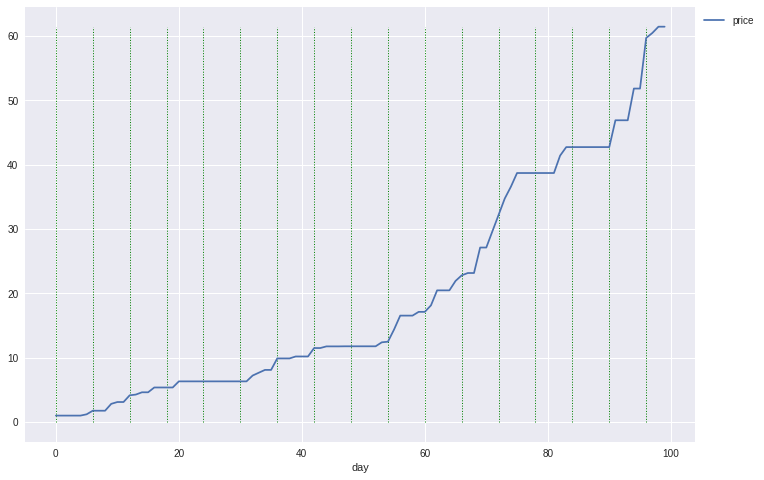

In [ ]:
df = pd.DataFrame({'price': price_projection['price'],'day': price_projection['day']}).assign(diff= lambda x: x['price'].diff())
#df['price'].plot(figsize=(12, 8))
df.plot(x='day',y='price',figsize=(12, 8))
plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left')
plt.vlines(x = [i for i in np.arange(0,days,half)], ymin=0,ymax=max(price_projection['price']), colors='green', ls=':', lw=1, label='halving')
print('The max price for coin one is:', max(price_projection['price']))
print('It occurs on day: ',np.argmax(price_projection['price']))
print('The number of active users for coin one is: ',price_projection['size'][np.argmax(price_projection['price'])])
print('The size of the exposed network for coin one is: ',len(price_projection['currently_exposed'][np.argmax(price_projection['price'])-1]))
print('The number of nodes on the graph is: ',n)
print('The probability of sharing info about coin one if interested buyer is: ', prob)
print('The probability of sharing info about coin one if NOT interested buyer is: ', no_prob)
print('The degree distribution is Poission with rate: ',q)
print('The halving period for coin one is: ',half,' days')

The max price for coin two is: 0.25
It occurs on day:  0
The number of active users trading coin two is:  0
The size of the exposed network for coin two is:  8
The number of nodes on the graph is:  202
The probability of sharing info about coin two if interested buyer is:  0.03
The probability of sharing info about coin two if NOT interested buyer is:  0.01
The degree distribution is Poission with rate:  0.015
The halving period for coin two is:  6  days
Coin two dropped  5  days after coin one


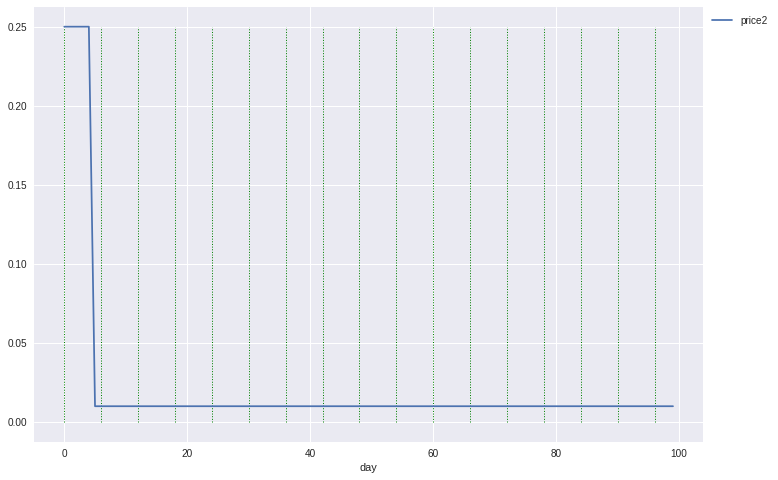

In [ ]:
df2 = pd.DataFrame({'price2': price_projection['price2'],'day': price_projection['day'][0:days]}).assign(diff= lambda x: x['price2'].diff())
df2.plot(x='day',y='price2',figsize=(12, 8))
plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left')
plt.vlines(x = [i for i in np.arange(0,days,half2)], ymin=0,ymax=max(price_projection['price2']), colors='green', ls=':', lw=1, label='halving')
print('The max price for coin two is:', max(price_projection['price2']))
print('It occurs on day: ',np.argmax(price_projection['price2']))
print('The number of active users trading coin two is: ',price_projection['size2'][np.argmax(price_projection['price2'])])
print('The size of the exposed network for coin two is: ',len(price_projection['currently_exposed2'][np.argmax(price_projection['price2'])]))
print('The number of nodes on the graph is: ',n)
print('The probability of sharing info about coin two if interested buyer is: ', prob2)
print('The probability of sharing info about coin two if NOT interested buyer is: ', no_prob2)
print('The degree distribution is Poission with rate: ',q)
print('The halving period for coin two is: ',half2,' days')
print('Coin two dropped ', day2,' days after coin one')

Valuations

In [ ]:
print(price_projection['valuation'])

[[0.9219131181915885, 1.0889050365858577, 0.5850059015316227, 1.3040115871264961, 0.6481851123741553, 1.1237956979062076, 1.3597423250387597, 0.2886555568710891, 1.6917589257196495, 1.035096305282805, 0.9701162428674825, 1.2090752159336124, 0.6253127884330933, 1.4647242569683159, 1.246834983839229, 0.6527949944230995, 2.138406214609461, 0.920418278592176, 1.5996112173023982, 0.1895403127826938, 0.5265535618234897, 0.1298551245233467, 0.66901989665819, 0.21829073648998631, 1.2027763372900824, 0.8143856261432314, 1.173974534583556, 1.3541088554604537, 1.5050280377797933, 1.4266649272546685, 0.36098467971178905, 0.3484100026862573, 0.1992801141342707, 1.360023285353284, 2.022793199334133, 1.5898674981691752, 0.5402285535296899, 1.1350600765370322, 1.3792088472817337, 2.345881726597579, 1.7169649189296505, 1.9721607328975108, 1.7642615299921127, 1.6476601815607383, 0.6650497544565482, 0.581551366858713, 0.4752243060867487, 0.547819532339151, 1.4910250860105916, 0.7881722569338999, 1.614600

In [ ]:
print(price_projection['valuation2'])

[[0.4988112960811336, 0.2561649954440199, 0.35950336984115605, 0.38150976822126265, 0.2657774815579968, 0.1728530078335513, 0.11494584088297982, 0.27141333214582286, 0.23294188203327879, 0.20463535859894436, 0.13296046936262468, 0.24562359991343757, 0.2551011451978229, 0.2894526490878264, 0.17589421812223222, 0.19344168644827933, 0, 0.5727950694393495, 0.4050713783816987, 0.28569987162029076, 0.047128643289341965, 0.31515560328525827, 0.3480965218044602, 0.2382320704323497, 0.23213578745348407, 0.4052418965762979, 0.15291224398532172, 0.21898921881429148, 0.2896787073910391, 0.2674610733703942, 0.3754288981332313, 0.17951343568026662, 0.34969409908092275, 0.3931524786302466, 0.09904521970139282, 0, 0.1585107717870491, 0.3652757637835346, 0.3267450502112874, 0.1705190158443401, 0.10703539139864596, 0.4274266422738191, 0.3045345014344996, 0.185461453692069, 0.15324159778199536, 0.25514194014785474, 0.3471944885362046, 0.37126766152690055, 0.286805215171001, 0.2139184684521482, 0.22650068

Analysis

In [ ]:
price_projection['spike_days']
price_projection['spike_days2']
price_projection['many_iterations']
price_projection['many_iterations2']


print('The price for coin one spiked ', len(price_projection['spike_days']), 'times.')
print('The price for coin two spiked ', len(price_projection['spike_days2']), 'times.')
print('There were ', len(price_projection['many_iterations']), 'times that coin one program exceeded allowable iterations')
print('There were ', len(price_projection['many_iterations2']), 'times that coin two program exceeded allowable iterations')
print('On days with too many iterations, price set to max(initial_price,wmedian_coin_value)')
print('weighted median list for overflow',price_projection['wmedian_lst'])
print('weighted median list 2 for overflow',price_projection['wmedian_lst2'])
print('The days of overflow for coin one are: ',price_projection['many_iterations'])
print('The days of overflow for coin two are: ',price_projection['many_iterations2'])
print('Days coin 1 was chosen over coin 2: ',price_projection['coin_1_over_coin_2'])
print('Days coin 2 was chosen over coin 1: ',price_projection['coin_2_over_coin_1'])

In [ ]:
x = np.arange(0,days)
y1 = price_projection['price']
y2 = price_projection['price2']


figure, ax1 = plt.subplots(figsize=(12,8))

color = 'tab:blue'
ax1.set_xlabel('time (days)')
ax1.set_ylabel('price_coin_one_variable_income', color=color)
ax1.plot(x, y1, color=color)
ax1.tick_params(axis='y', labelcolor=color)


ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('price_coin_two_variable_income', color=color)  # we already handled the x-label with ax1
ax2.plot(x,y2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

#fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.vlines(x = [i for i in np.arange(0,days,half)], ymin=0,ymax=max(y2), colors='green', ls=':', lw=1, label='halving for coin two')
plt.vlines(x = [i for i in np.arange(0,days,half2)], ymin=0,ymax=max(y2), colors='grey', ls=':', lw=1, label='halving for coin two')
plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left')
plt.show()

print('The max price for coin one is:', max(price_projection['price']))
print('It occurs on day: ',np.argmax(price_projection['price']))
print('The max price for coin two is:', max(price_projection['price2']))
print('It occurs on day: ',np.argmax(price_projection['price2']))
print('The number of active users for coin one is: ',price_projection['size'][np.argmax(price_projection['price'])])
print('The number of active users for coin two is: ',price_projection['size2'][np.argmax(price_projection['price2'])])
print('The size of the exposed network for coin one is: ',len(price_projection['currently_exposed'][np.argmax(price_projection['price'])]))
print('The size of the exposed network for coin two is: ',len(price_projection['currently_exposed2'][np.argmax(price_projection['price2'])]))
print('The number of nodes on the graph is: ',n)
print('The probability of sharing info about coin one if interested buyer is: ', prob)
print('The probability of sharing info about coin one if NOT interested buyer is: ', no_prob)
print('The degree distribution is Poission with rate: ',q)
print('The probability of sharing info about coin two if interested buyer is: ', prob2)
print('The probability of sharing info about coin two if NOT interested buyer is: ', no_prob2)
print('The degree distribution is Poission with rate: ',q)
print('The halving period for coin one is: ',half,' days')
print('The halving period for coin two is: ',half2,' days')
print('Coin two dropped ', day2,' days after coin one')

## Comparing price for both coins:

In [ ]:
#convert to time series

price_series = pd.Series(price_projection['price'])
price_series2 = pd.Series(price_projection['price2'])

# plot time series
price_series.plot(style='k',figsize=(12,8),label='price_coin_one_variable income')
price_series2.plot(style='g',figsize=(12,8),label='price_coin_two_variable income')

plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left')
plt.show()

## More Analysis - need to fix this and below


In [ ]:
x = np.arange(1,days)
y1 = price_projection['current_infected']
y2 = np.array(price_projection['coin_count'])


figure, ax1 = plt.subplots(figsize=(12,8))

color = 'tab:blue'
ax1.set_xlabel('time (days)')
ax1.set_ylabel('size of network', color=color)
ax1.plot(x, y1, color=color)
ax1.tick_params(axis='y', labelcolor=color)


ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('supply of coin one', color=color)  # we already handled the x-label with ax1
ax2.plot(x,y2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

#fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.vlines(x = [i for i in np.arange(0,days,half)], ymin=0,ymax=max(y2), colors='green', ls=':', lw=1, label='halving')
plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left')
plt.show()

print('The max price is:', max(price_projection['price']))
print('It occurs on day: ',np.argmax(price_projection['price']))
print('The number of active users is: ',price_projection['size'][np.argmax(price_projection['price'])])
print('The size of the exposed network is: ',len(price_projection['currently_exposed'][np.argmax(price_projection['price'])]))
print('The number of nodes on the graph is: ',n)
print('The probability of sharing if interested buyer is: ', prob)
print('The probability of sharing if NOT interested buyer is: ', no_prob)
print('The degree distribution is Poission with rate: ',q)
print('The halving period is: ',half,' days')

In [ ]:
x = np.arange(1,days)
y1 = price_projection['current_infected2']
y2 = np.array(price_projection['coin_count2'])


figure, ax1 = plt.subplots(figsize=(12,8))

color = 'tab:blue'
ax1.set_xlabel('time (days)')
ax1.set_ylabel('size of network', color=color)
ax1.plot(x, y1, color=color)
ax1.tick_params(axis='y', labelcolor=color)


ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('supply of coin two', color=color)  # we already handled the x-label with ax1
ax2.plot(x,y2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

#fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.vlines(x = [i for i in np.arange(0,days,half)], ymin=0,ymax=max(y2), colors='green', ls=':', lw=1, label='halving')
plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left')
plt.show()

print('The max price is:', max(price_projection['price']))
print('It occurs on day: ',np.argmax(price_projection['price']))
print('The number of active users is: ',price_projection['size'][np.argmax(price_projection['price'])])
print('The size of the exposed network is: ',len(price_projection['currently_exposed'][np.argmax(price_projection['price'])]))
print('The number of nodes on the graph is: ',n)
print('The probability of sharing if interested buyer is: ', prob)
print('The probability of sharing if NOT interested buyer is: ', no_prob)
print('The degree distribution is Poission with rate: ',q)
print('The halving period is: ',half,' days')

In [ ]:
x = np.arange(1,days)
y1 = price_projection['coin_count']
y2 = np.array(price_projection['coin_count2'])


figure, ax1 = plt.subplots(figsize=(12,8))

color = 'tab:blue'
ax1.set_xlabel('time (days)')
ax1.set_ylabel('supply of coin one', color=color)
ax1.plot(x, y1, color=color)
ax1.tick_params(axis='y', labelcolor=color)


ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('supply of coin two', color=color)  # we already handled the x-label with ax1
ax2.plot(x,y2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

#fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.vlines(x = [i for i in np.arange(0,days,half)], ymin=0,ymax=max(y2), colors='green', ls=':', lw=1, label='halving')
plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left')
plt.show()

print('The max price is:', max(price_projection['price']))
print('It occurs on day: ',np.argmax(price_projection['price']))
print('The number of active users is: ',price_projection['size'][np.argmax(price_projection['price'])])
print('The size of the exposed network is: ',len(price_projection['currently_exposed'][np.argmax(price_projection['price'])]))
print('The number of nodes on the graph is: ',n)
print('The probability of sharing if interested buyer is: ', prob)
print('The probability of sharing if NOT interested buyer is: ', no_prob)
print('The degree distribution is Poission with rate: ',q)
print('The halving period is: ',half,' days')

# Analysis:

## Looking at variance in price -- variable income

##Looking at Variance - 2 Day window

In [ ]:
#convert to time series

price_series = pd.Series(price_projection['price'])

# plot time series
price_series.plot(style='k',figsize=(12,8),label='price')

#calculate rolling variance and plot -- 2 day window
price_series.rolling(window=2).var().plot(style='b',label='var')

#calculate rolling std and plot -- s day window
price_series.rolling(window=2).std().plot(style = 'r',label='std')

plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left')
plt.show()

In [ ]:
price_series.rolling(window=2).std().plot(style = 'r',label='std')

In [ ]:
price_series.rolling(window=2).var().plot(style = 'r',label='std')

## Looking at variance -- 7 day window

In [ ]:
#convert to time series

price_series = pd.Series(price_projection['price'])

# plot time series
price_series.plot(style='k',figsize=(12,8),label='price_coin_one')

#calculate rolling variance and plot -- 2 day window
price_series.rolling(window=7).var().plot(style='b',label='var')

#calculate rolling std and plot -- s day window
price_series.rolling(window=7).std().plot(style = 'r',label='std')

plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left')
plt.show()

In [ ]:
price_series.rolling(window=7).std().plot(style = 'r',label='std')

In [ ]:
price_series.rolling(window=7).var().plot(style = 'r',label='std')

## Looking at variance in price -- fixed income

## 2 Day window

In [ ]:
#convert to time series

price2_series = pd.Series(price_projection['price2'])

# plot time series
price2_series.plot(style='k',figsize=(12,8),label='price_coin_two_fixed income')

#calculate rolling variance and plot -- 2 day window
price2_series.rolling(window=2).var().plot(style='b',label='var')

#calculate rolling std and plot -- s day window
price2_series.rolling(window=2).std().plot(style = 'r',label='std')

plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left')
plt.show()

In [ ]:
price2_series.rolling(window=2).std().plot(style = 'r',label='std')

In [ ]:
price2_series.rolling(window=2).var().plot(style = 'r',label='std')

## 7 day window

In [ ]:
#convert to time series

price2_series = pd.Series(price_projection['price2'])

# plot time series
price2_series.plot(style='k',figsize=(12,8),label='price_coin_two_fixed income')

#calculate rolling variance and plot -- 2 day window
price2_series.rolling(window=7).var().plot(style='b',label='var')

#calculate rolling std and plot -- s day window
price2_series.rolling(window=7).std().plot(style = 'r',label='std')

plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left')
plt.show()

In [ ]:
price2_series.rolling(window=7).std().plot(style = 'r',label='std')

In [ ]:
price2_series.rolling(window=7).var().plot(style = 'r',label='std')

## 2 Day window

In [ ]:
x = np.arange(0,days)
price_std = price_series.rolling(window=2).std()
price2_std = price2_series.rolling(window=2).std()

figure, ax1 = plt.subplots(figsize=(12,8))

color = 'tab:blue'
ax1.set_xlabel('time (days)')
ax1.set_ylabel('std_coin_one', color='red')
ax1.plot(x, price_std, color='red')
ax1.tick_params(axis='y', labelcolor='red')


ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('std_coin_two', color='blue')  # we already handled the x-label with ax1
ax2.plot(x,price2_std, color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

#fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.vlines(x = [i for i in np.arange(0,days,half)], ymin=0,ymax=max(max(price2_std),max(price_std)), colors='green', ls=':', lw=1, label='halving')
plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left')
plt.show()

## 7 Day window

In [ ]:
x = np.arange(0,days)
price_std = price_series.rolling(window=7).std()
price2_std = price2_series.rolling(window=7).std()

figure, ax1 = plt.subplots(figsize=(12,8))

color = 'tab:blue'
ax1.set_xlabel('time (days)')
ax1.set_ylabel('std_coin_one', color='red')
ax1.plot(x, price_std, color='red')
ax1.tick_params(axis='y', labelcolor='red')


ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('std_coin_two', color='blue')  # we already handled the x-label with ax1
ax2.plot(x,price2_std, color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

#fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.vlines(x = [i for i in np.arange(0,days,half)], ymin=0,ymax=max(max(price2_std),max(price_std)), colors='green', ls=':', lw=1, label='halving')
plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left')
plt.show()

## Size of Network of coin one vs Time

In [ ]:
#Linear fit

#create data
time = np.linspace(1,days,days - 1) #day
size = np.array(price_projection['current_infected']) #network size

#use green as color for individual points
plt.plot(time, size, 'o', color='green')
#plt.plot(x = 'network size', y = 'price', 'o', color='green')

#obtain m (slope) and b(intercept) of linear regression line
#a, b, c = np.polyfit(size, price, 2)
linmodel = np.poly1d(np.polyfit(time,size,1))

#use red as color for regression line
plt.plot(time, linmodel(time), color='red')

#plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left')

r2_line = r2_score(size, linmodel(time))

print('r^2 value is: ',r2_line)

In [ ]:
#Quadratic fit

#create data
time = np.linspace(1,days,days - 1) #day
size = np.array(price_projection['current_infected']) #network size

#use green as color for individual points
plt.plot(time, size, 'o', color='green')
#plt.plot(x = 'network size', y = 'price', 'o', color='green')

#obtain m (slope) and b(intercept) of linear regression line
#a, b, c = np.polyfit(size, price, 2)
quadmodel = np.poly1d(np.polyfit(time,size,2))

#use red as color for regression line
plt.plot(time, quadmodel(time), color='red')

#plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left')

r2_quad = r2_score(size, quadmodel(time))

print('r^2 value is: ',r2_quad)

In [ ]:
#Log fit

#create data
time = np.linspace(1,days,days - 1) #day
size = np.array(price_projection['current_infected']) #network size

log_time = np.log(time)

#use green as color for individual points
plt.plot(time, size, 'o', color='green')
#plt.plot(x = 'network size', y = 'price', 'o', color='green')

#obtain m (slope) and b(intercept) of linear regression line
#a, b, c = np.polyfit(size, price, 2)
logmodel = np.poly1d(np.polyfit(log_time,size,1))

#use red as color for regression line
plt.plot(time, logmodel(log_time), color='red')

#plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left')

r2_log = r2_score(size, logmodel(log_time))

print('r^2 value is: ',r2_log)

In [ ]:
#Exponential fit

#create data
time = np.linspace(1,days,days - 1) #day
size = np.array(price_projection['current_infected']) #network size  

# Function to calculate the exponential with constants a and b
def exponential(x, a, b):
    return a*np.exp(b*x)

pars, cov = curve_fit(f=exponential, xdata=time, ydata=size, p0=[0, 0], maxfev=100000, bounds=(-np.inf, np.inf))

# Get the standard deviations of the parameters (square roots of the # diagonal of the covariance)
stdevs = np.sqrt(np.diag(cov))# Calculate the residuals
res = size - exponential(time, *pars)

plt.plot(time, size, 'o', color='green')
plt.plot(time, exponential(time, *pars), linestyle='-', linewidth=2, color='red')

ss_res = np.sum(res**2)
ss_tot = np.sum((size - np.mean(size))**2)

r2_expo = 1 - (ss_res / ss_tot)

print('r^2 value is: ', r2_expo)
print('standard deviation: ', stdevs)
print('residuals: ',res)

print('The parameters for y = a*exp(bx) are: ', pars)

In [ ]:
#S-curve fit

#create data
time = np.linspace(1,days,days - 1) #day
size = np.array(price_projection['current_infected']) #network size 

xdata=time
ydata=size
p0 = [max(ydata), np.median(xdata),1,min(ydata)]

# Function to calculate the S-curve with constants a, b, and c
def scurve(x, L ,x0, k, b): #Using a sigmoid curve as the fit curve
    y = L / (1 + np.exp(-k*(x-x0)))+b
    return (y)

pars, cov = curve_fit(f=scurve, xdata=time, ydata=size, p0 = [max(ydata), np.median(xdata),1,min(ydata)], maxfev=1000000, method='dogbox',bounds=(-np.inf, np.inf))

# Get the standard deviations of the parameters (square roots of the # diagonal of the covariance)
stdevs = np.sqrt(np.diag(cov))# Calculate the residuals
res = size - scurve(time, *pars)

plt.plot(time, size, 'o', color='green')
plt.plot(time, scurve(time, *pars), linestyle='-', linewidth=2, color='red')

ss_res = np.sum(res**2)
ss_tot = np.sum((size - np.mean(size))**2)

r2_scurve = 1 - (ss_res / ss_tot)

print('r^2 value is: ', r2_scurve)
print('standard deviation: ', stdevs)
print('residuals: ',res)

print('The parameters for y = 1/(a + b*np.exp(-c*x)) are: ', pars)

In [ ]:
#nLogn fit

#create data
time = np.linspace(1,days,days - 1) #day
size = np.array(price_projection['current_infected']) #network size

nlogn_time = time*np.log(time) 

#use green as color for individual points
plt.plot(time, size, 'o', color='green')
#plt.plot(x = 'network size', y = 'price', 'o', color='green')

#obtain m (slope) and b(intercept) of linear regression line
#a, b, c = np.polyfit(size, price, 2)
nlognmodel = np.poly1d(np.polyfit(nlogn_time,size,2))

#use red as color for regression line
plt.plot(time, nlognmodel(nlogn_time), color='red')

#plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left')

r2_nlogn = r2_score(size, nlognmodel(nlogn_time))

print('r^2 value is: ',r2_nlogn)

In [ ]:
print('r2_expo: ',r2_expo)
print('r2_line: ',r2_line)
print('r2_log: ',r2_log)
print('r2_quad: ',r2_quad)
print('r2_nlogn: ',r2_nlogn)
print('r2_scurve: ',r2_scurve,'\n \n')

if max(r2_expo, r2_line, r2_log, r2_quad, r2_nlogn, r2_scurve) ==  r2_expo:
  print('e^n is best fit for size vs time')

if max(r2_expo, r2_line, r2_log, r2_quad, r2_nlogn, r2_scurve) ==  r2_line:
  print('line is best fit for size vs time')

if max(r2_expo, r2_line, r2_log, r2_quad, r2_nlogn, r2_scurve) ==  r2_quad:
  print('n^2 is best fit for size vs time')

if max(r2_expo, r2_line, r2_log, r2_quad, r2_nlogn, r2_scurve) ==  r2_log:
  print('log n is best fit for size vs time')

if max(r2_expo, r2_line, r2_log, r2_quad, r2_nlogn, r2_scurve) ==  r2_nlogn:
  print('nlogn is best fit for size vs time')

if max(r2_expo, r2_line, r2_log, r2_quad, r2_nlogn, r2_scurve) ==  r2_scurve:
  print('a sigmoid curve is best fit for size vs time')

## Size of Network of coin two vs Time

In [ ]:
#Linear fit

#create data
time = np.linspace(1,days,days - 1) #day
size = np.array(price_projection['current_infected2']) #network size

#use green as color for individual points
plt.plot(time, size, 'o', color='green')
#plt.plot(x = 'network size', y = 'price', 'o', color='green')

#obtain m (slope) and b(intercept) of linear regression line
#a, b, c = np.polyfit(size, price, 2)
linmodel = np.poly1d(np.polyfit(time,size,1))

#use red as color for regression line
plt.plot(time, linmodel(time), color='red')

#plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left')

r2_line = r2_score(size, linmodel(time))

print('r^2 value is: ',r2_line)

In [ ]:
#Quadratic fit

#create data
time = np.linspace(1,days,days - 1) #day
size = np.array(price_projection['current_infected2']) #network size

#use green as color for individual points
plt.plot(time, size, 'o', color='green')
#plt.plot(x = 'network size', y = 'price', 'o', color='green')

#obtain m (slope) and b(intercept) of linear regression line
#a, b, c = np.polyfit(size, price, 2)
quadmodel = np.poly1d(np.polyfit(time,size,2))

#use red as color for regression line
plt.plot(time, quadmodel(time), color='red')

#plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left')

r2_quad = r2_score(size, quadmodel(time))

print('r^2 value is: ',r2_quad)

In [ ]:
#Log fit

#create data
time = np.linspace(1,days,days - 1) #day
size = np.array(price_projection['current_infected2']) #network size

log_time = np.log(time)

#use green as color for individual points
plt.plot(time, size, 'o', color='green')
#plt.plot(x = 'network size', y = 'price', 'o', color='green')

#obtain m (slope) and b(intercept) of linear regression line
#a, b, c = np.polyfit(size, price, 2)
logmodel = np.poly1d(np.polyfit(log_time,size,1))

#use red as color for regression line
plt.plot(time, logmodel(log_time), color='red')

#plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left')

r2_log = r2_score(size, logmodel(log_time))

print('r^2 value is: ',r2_log)

In [ ]:
#Exponential fit

#create data
time = np.linspace(1,days,days - 1) #day
size = np.array(price_projection['current_infected2']) #network size  

# Function to calculate the exponential with constants a and b
def exponential(x, a, b):
    return a*np.exp(b*x)

pars, cov = curve_fit(f=exponential, xdata=time, ydata=size, p0=[0, 0], maxfev=100000, bounds=(-np.inf, np.inf))

# Get the standard deviations of the parameters (square roots of the # diagonal of the covariance)
stdevs = np.sqrt(np.diag(cov))# Calculate the residuals
res = size - exponential(time, *pars)

plt.plot(time, size, 'o', color='green')
plt.plot(time, exponential(time, *pars), linestyle='-', linewidth=2, color='red')

ss_res = np.sum(res**2)
ss_tot = np.sum((size - np.mean(size))**2)

r2_expo = 1 - (ss_res / ss_tot)

print('r^2 value is: ', r2_expo)
print('standard deviation: ', stdevs)
print('residuals: ',res)

print('The parameters for y = a*exp(bx) are: ', pars)

In [ ]:
#S-curve fit

#create data
time = np.linspace(1,days,days - 1) #day
size = np.array(price_projection['current_infected2']) #network size 

xdata=time
ydata=size
p0 = [max(ydata), np.median(xdata),1,min(ydata)]

# Function to calculate the S-curve with constants a, b, and c
def scurve(x, L ,x0, k, b): #Using a sigmoid curve as the fit curve
    y = L / (1 + np.exp(-k*(x-x0)))+b
    return (y)

pars, cov = curve_fit(f=scurve, xdata=time, ydata=size, p0 = [max(ydata), np.median(xdata),1,min(ydata)], maxfev=1000000, method='dogbox',bounds=(-np.inf, np.inf))

# Get the standard deviations of the parameters (square roots of the # diagonal of the covariance)
stdevs = np.sqrt(np.diag(cov))# Calculate the residuals
res = size - scurve(time, *pars)

plt.plot(time, size, 'o', color='green')
plt.plot(time, scurve(time, *pars), linestyle='-', linewidth=2, color='red')

ss_res = np.sum(res**2)
ss_tot = np.sum((size - np.mean(size))**2)

r2_scurve = 1 - (ss_res / ss_tot)

print('r^2 value is: ', r2_scurve)
print('standard deviation: ', stdevs)
print('residuals: ',res)

print('The parameters for y = 1/(a + b*np.exp(-c*x)) are: ', pars)

In [ ]:
#nLogn fit

#create data
time = np.linspace(1,days,days - 1) #day
size = np.array(price_projection['current_infected2']) #network size

nlogn_time = time*np.log(time) 

#use green as color for individual points
plt.plot(time, size, 'o', color='green')
#plt.plot(x = 'network size', y = 'price', 'o', color='green')

#obtain m (slope) and b(intercept) of linear regression line
#a, b, c = np.polyfit(size, price, 2)
nlognmodel = np.poly1d(np.polyfit(nlogn_time,size,2))

#use red as color for regression line
plt.plot(time, nlognmodel(nlogn_time), color='red')

#plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left')

r2_nlogn = r2_score(size, nlognmodel(nlogn_time))

print('r^2 value is: ',r2_nlogn)

In [ ]:
print('r2_expo: ',r2_expo)
print('r2_line: ',r2_line)
print('r2_log: ',r2_log)
print('r2_quad: ',r2_quad)
print('r2_nlogn: ',r2_nlogn)
print('r2_scurve: ',r2_scurve,'\n \n')

if max(r2_expo, r2_line, r2_log, r2_quad, r2_nlogn, r2_scurve) ==  r2_expo:
  print('e^n is best fit for size vs time')

if max(r2_expo, r2_line, r2_log, r2_quad, r2_nlogn, r2_scurve) ==  r2_line:
  print('line is best fit for size vs time')

if max(r2_expo, r2_line, r2_log, r2_quad, r2_nlogn, r2_scurve) ==  r2_quad:
  print('n^2 is best fit for size vs time')

if max(r2_expo, r2_line, r2_log, r2_quad, r2_nlogn, r2_scurve) ==  r2_log:
  print('log n is best fit for size vs time')

if max(r2_expo, r2_line, r2_log, r2_quad, r2_nlogn, r2_scurve) ==  r2_nlogn:
  print('nlogn is best fit for size vs time')

if max(r2_expo, r2_line, r2_log, r2_quad, r2_nlogn, r2_scurve) ==  r2_scurve:
  print('a sigmoid curve is best fit for size vs time')

## Price of coin one vs Time (variable income)

In [ ]:
#Linear fit

#create data
time = np.arange(0,days)
#time = np.linspace(1,days,days - 1) #day
price = np.array(price_projection['price']) #price

#use green as color for individual points
plt.plot(time, price, 'o', color='green')
#plt.plot(x = 'network size', y = 'price', 'o', color='green')

#obtain m (slope) and b(intercept) of linear regression line
#a, b, c = np.polyfit(size, price, 2)
linmodel = np.poly1d(np.polyfit(time,price,1))

#use red as color for regression line
plt.plot(time, linmodel(time), color='red')

#plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left')

r2_line = r2_score(price, linmodel(time))

print('Variable Income')

print('r^2 value is: ',r2_line)

In [ ]:
#Quadratic fit

#create data
time = np.arange(0,days)
#time = np.linspace(1,days,days - 1) #day
price = np.array(price_projection['price']) #price

#use green as color for individual points
plt.plot(time, price, 'o', color='green')
#plt.plot(x = 'network size', y = 'price', 'o', color='green')

#obtain m (slope) and b(intercept) of linear regression line
#a, b, c = np.polyfit(size, price, 2)
quadmodel = np.poly1d(np.polyfit(time,price,2))

#use red as color for regression line
plt.plot(time, quadmodel(time), color='red')

#plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left')

r2_quad = r2_score(price, quadmodel(time))

print('Variable Income')

print('r^2 value is: ',r2_quad)

In [ ]:
# #Log fit

# #create data
# time = np.arange(0,days)
# #time = np.linspace(1,days,days - 1) #day
# price = np.array(price_projection['price']) #price

# log_time = np.log(time)

# #use green as color for individual points
# plt.plot(time, price, 'o', color='green')
# #plt.plot(x = 'network size', y = 'price', 'o', color='green')

# #obtain m (slope) and b(intercept) of linear regression line
# #a, b, c = np.polyfit(size, price, 2)
# logmodel = np.poly1d(np.polyfit(log_time,price,1))

# #use red as color for regression line
# plt.plot(time, logmodel(log_time), color='red')

# #plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left')

# r2_log = r2_score(price, logmodel(log_time))

# print('Variable Income')

# print('r^2 value is: ',r2_log)

In [ ]:
#Exponential fit

#create data
time = np.arange(0,days)
#time = np.linspace(1,days,days - 1) #day
price = np.array(price_projection['price']) #price 

# Function to calculate the exponential with constants a and b
def exponential(x, a, b):
    return a*np.exp(b*x)

pars, cov = curve_fit(f=exponential, xdata=time, ydata=price, p0=[0, 0], maxfev=100000, bounds=(-np.inf, np.inf))

# Get the standard deviations of the parameters (square roots of the # diagonal of the covariance)
stdevs = np.sqrt(np.diag(cov))# Calculate the residuals
res = price - exponential(time, *pars)

plt.plot(time, price, 'o', color='green')
plt.plot(time, exponential(time, *pars), linestyle='-', linewidth=2, color='red')

ss_res = np.sum(res**2)
ss_tot = np.sum((price - np.mean(price))**2)

r2_expo = 1 - (ss_res / ss_tot)

print('Variable Income')

print('r^2 value is: ', r2_expo)
print('standard deviation: ', stdevs)
print('residuals: ',res)

print('The parameters for y = a*exp(bx) are: ', pars)

In [ ]:
# #nLogn fit

# #create data
# time = np.arange(0,days)
# #time = np.linspace(1,days,days - 1) #day
# price = np.array(price_projection['price']) #price

# nlogn_time = time*np.log(time) 

# #use green as color for individual points
# plt.plot(time, price, 'o', color='green')
# #plt.plot(x = 'network size', y = 'price', 'o', color='green')

# #obtain m (slope) and b(intercept) of linear regression line
# #a, b, c = np.polyfit(size, price, 2)
# nlognmodel = np.poly1d(np.polyfit(nlogn_time,price,2))

# #use red as color for regression line
# plt.plot(time, nlognmodel(nlogn_time), color='red')

# #plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left')

# r2_nlogn = r2_score(price, nlognmodel(nlogn_time))

# print('Variable Income')

# print('r^2 value is: ',r2_nlogn)

In [ ]:
print('Variable Income')

print('r2_expo: ',r2_expo)
print('r2_line: ',r2_line)
print('r2_log: ',r2_log)
print('r2_quad: ',r2_quad)
print('r2_nlogn: ',r2_nlogn)

if max(r2_expo, r2_line, r2_log, r2_quad, r2_nlogn) ==  r2_expo:
  print('e^n is best fit for price vs time')

if max(r2_expo, r2_line, r2_log, r2_quad, r2_nlogn) ==  r2_line:
  print('line is best fit for price vs time')

if max(r2_expo, r2_line, r2_log, r2_quad, r2_nlogn) ==  r2_quad:
  print('n^2 is best fit for price vs time')

if max(r2_expo, r2_line, r2_log, r2_quad, r2_nlogn) ==  r2_log:
  print('log n is best fit for price vs time')

if max(r2_expo, r2_line, r2_log, r2_quad, r2_nlogn) ==  r2_nlogn:
  print('nlogn is best fit for price vs time')

## Price of coin two vs Time (variable income)

In [ ]:
#Linear fit

#create data
time = np.arange(0,days)
#time = np.linspace(1,days,days - 1) #day
price = np.array(price_projection['price2']) #price

#use green as color for individual points
plt.plot(time, price, 'o', color='green')
#plt.plot(x = 'network size', y = 'price', 'o', color='green')

#obtain m (slope) and b(intercept) of linear regression line
#a, b, c = np.polyfit(size, price, 2)
linmodel = np.poly1d(np.polyfit(time,price,1))

#use red as color for regression line
plt.plot(time, linmodel(time), color='red')

#plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left')

r2_line = r2_score(price, linmodel(time))

print('Variable Income')

print('r^2 value is: ',r2_line)

In [ ]:
#Quadratic fit

#create data
time = np.arange(0,days)
#time = np.linspace(1,days,days - 1) #day
price = np.array(price_projection['price2']) #price

#use green as color for individual points
plt.plot(time, price, 'o', color='green')
#plt.plot(x = 'network size', y = 'price', 'o', color='green')

#obtain m (slope) and b(intercept) of linear regression line
#a, b, c = np.polyfit(size, price, 2)
quadmodel = np.poly1d(np.polyfit(time,price,2))

#use red as color for regression line
plt.plot(time, quadmodel(time), color='red')

#plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left')

r2_quad = r2_score(price, quadmodel(time))

print('Variable Income')

print('r^2 value is: ',r2_quad)

In [ ]:
# #Log fit

# #create data
# time = np.arange(0,days)
# #time = np.linspace(1,days,days - 1) #day
# price = np.array(price_projection['price2']) #price

# log_time = np.log(time)

# #use green as color for individual points
# plt.plot(time, price, 'o', color='green')
# #plt.plot(x = 'network size', y = 'price', 'o', color='green')

# #obtain m (slope) and b(intercept) of linear regression line
# #a, b, c = np.polyfit(size, price, 2)
# logmodel = np.poly1d(np.polyfit(log_time,price,1))

# #use red as color for regression line
# plt.plot(time, logmodel(log_time), color='red')

# #plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left')

# r2_log = r2_score(price, logmodel(log_time))

# print('Variable Income')

# print('r^2 value is: ',r2_log)

In [ ]:
#Exponential fit

#create data
time = np.arange(0,days)
#time = np.linspace(1,days,days - 1) #day
price = np.array(price_projection['price2']) #price 

# Function to calculate the exponential with constants a and b
def exponential(x, a, b):
    return a*np.exp(b*x)

pars, cov = curve_fit(f=exponential, xdata=time, ydata=price, p0=[0, 0], maxfev=100000, bounds=(-np.inf, np.inf))

# Get the standard deviations of the parameters (square roots of the # diagonal of the covariance)
stdevs = np.sqrt(np.diag(cov))# Calculate the residuals
res = price - exponential(time, *pars)

plt.plot(time, price, 'o', color='green')
plt.plot(time, exponential(time, *pars), linestyle='-', linewidth=2, color='red')

ss_res = np.sum(res**2)
ss_tot = np.sum((price - np.mean(price))**2)

r2_expo = 1 - (ss_res / ss_tot)

print('Variable Income')

print('r^2 value is: ', r2_expo)
print('standard deviation: ', stdevs)
print('residuals: ',res)

print('The parameters for y = a*exp(bx) are: ', pars)

In [ ]:
# #nLogn fit

# #create data
# time = np.arange(0,days)
# #time = np.linspace(1,days,days - 1) #day
# price = np.array(price_projection['price2']) #price

# nlogn_time = time*np.log(time) 

# #use green as color for individual points
# plt.plot(time, price, 'o', color='green')
# #plt.plot(x = 'network size', y = 'price', 'o', color='green')

# #obtain m (slope) and b(intercept) of linear regression line
# #a, b, c = np.polyfit(size, price, 2)
# nlognmodel = np.poly1d(np.polyfit(nlogn_time,price,2))

# #use red as color for regression line
# plt.plot(time, nlognmodel(nlogn_time), color='red')

# #plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left')

# r2_nlogn = r2_score(price, nlognmodel(nlogn_time))

# print('Variable Income')

# print('r^2 value is: ',r2_nlogn)

In [ ]:
print('Variable Income')

print('r2_expo: ',r2_expo)
print('r2_line: ',r2_line)
print('r2_log: ',r2_log)
print('r2_quad: ',r2_quad)
print('r2_nlogn: ',r2_nlogn)

if max(r2_expo, r2_line, r2_log, r2_quad, r2_nlogn) ==  r2_expo:
  print('e^n is best fit for price vs time')

if max(r2_expo, r2_line, r2_log, r2_quad, r2_nlogn) ==  r2_line:
  print('line is best fit for price vs time')

if max(r2_expo, r2_line, r2_log, r2_quad, r2_nlogn) ==  r2_quad:
  print('n^2 is best fit for price vs time')

if max(r2_expo, r2_line, r2_log, r2_quad, r2_nlogn) ==  r2_log:
  print('log n is best fit for price vs time')

if max(r2_expo, r2_line, r2_log, r2_quad, r2_nlogn) ==  r2_nlogn:
  print('nlogn is best fit for price vs time')

## Price of coin one vs Network Size (Variable income)

In [ ]:
# #Linear fit

# #create data
# size = np.array(price_projection['current_infected']) #network size
# price = np.array(price_projection['price']) #price

# #use green as color for individual points
# plt.plot(size, price, 'o', color='green')
# #plt.plot(x = 'network size', y = 'price', 'o', color='green')

# #obtain m (slope) and b(intercept) of linear regression line
# #a, b, c = np.polyfit(size, price, 2)
# linmodel = np.poly1d(np.polyfit(size,price,1))

# #use red as color for regression line
# plt.plot(size, linmodel(size), color='red')

# #plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left')

# r2_line = r2_score(price, linmodel(size))

# print('Variable Income')

# print('r^2 value is: ',r2_line)

In [ ]:
#Quadratic fit

#create data
size = np.array(price_projection['current_infected']) #network size
price = np.array(price_projection['price'][1:200]) #price

#use green as color for individual points
plt.plot(size, price, 'o', color='green')
#plt.plot(x = 'network size', y = 'price', 'o', color='green')

#obtain m (slope) and b(intercept) of linear regression line
#a, b, c = np.polyfit(size, price, 2)
quadmodel = np.poly1d(np.polyfit(size,price,2))

#use red as color for regression line
plt.plot(size, quadmodel(size), color='red')

#plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left')

r2_quad = r2_score(price, quadmodel(size))

print('Variable Income')

print('r^2 value is: ',r2_quad)

In [ ]:
# #Log fit

# #create data
# size = np.array(price_projection['current_infected']) #network size
# price = np.array(price_projection['price']) #price

# log_size = np.log(size)

# #use green as color for individual points
# plt.plot(size, price, 'o', color='green')
# #plt.plot(x = 'network size', y = 'price', 'o', color='green')

# #obtain m (slope) and b(intercept) of linear regression line
# #a, b, c = np.polyfit(size, price, 2)
# logmodel = np.poly1d(np.polyfit(log_size,price,1))

# #use red as color for regression line
# plt.plot(size, logmodel(log_size), color='red')

# #plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left')

# r2_log = r2_score(price, logmodel(log_size))

# print('Variable Income')

# print('r^2 value is: ',r2_log)

In [ ]:
#Exponential fit

#create data
size = np.array(price_projection['current_infected']) #network size
price = np.array(price_projection['price'][1:200]) #price     

# Function to calculate the exponential with constants a and b
def exponential(x, a, b):
    return a*np.exp(b*x)

pars, cov = curve_fit(f=exponential, xdata=size, ydata=price, p0=[0, 0], maxfev=100000, bounds=(-np.inf, np.inf))

# Get the standard deviations of the parameters (square roots of the # diagonal of the covariance)
stdevs = np.sqrt(np.diag(cov))# Calculate the residuals
res = price - exponential(size, *pars)

plt.plot(size, price, 'o', color='green')
plt.plot(size, exponential(size, *pars), linestyle='-', linewidth=2, color='red')

ss_res = np.sum(res**2)
ss_tot = np.sum((price - np.mean(price))**2)

r2_expo = 1 - (ss_res / ss_tot)

print('Variable Income')

print('r^2 value is: ', r2_expo)
print('standard deviation: ', stdevs)
print('residuals: ',res)

print('The parameters for y = a*exp(bx) are: ', pars)

In [ ]:
# #nLogn fit

# #create data
# size = np.array(price_projection['current_infected']) #network size
# price = np.array(price_projection['price']) #price

# nlogn_size = size*np.log(size) 

# #use green as color for individual points
# plt.plot(size, price, 'o', color='green')
# #plt.plot(x = 'network size', y = 'price', 'o', color='green')

# #obtain m (slope) and b(intercept) of linear regression line
# #a, b, c = np.polyfit(size, price, 2)
# nlognmodel = np.poly1d(np.polyfit(nlogn_size,price,2))

# #use red as color for regression line
# plt.plot(size, nlognmodel(nlogn_size), color='red')

# #plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left')

# r2_nlogn = r2_score(price, nlognmodel(nlogn_size))

# print('Variable Income')

# print('r^2 value is: ',r2_nlogn)

In [ ]:
print('Variable Income')

print('r2_expo: ',r2_expo)
print('r2_line: ',r2_line)
print('r2_log: ',r2_log)
print('r2_quad: ',r2_quad)
print('r2_nlogn: ',r2_nlogn)
print('r2_scurve: ',r2_scurve,'\n \n')

if max(r2_expo, r2_line, r2_log, r2_quad, r2_nlogn, r2_scurve) ==  r2_expo:
  print('e^n is best fit for size vs time for first 50 days')

if max(r2_expo, r2_line, r2_log, r2_quad, r2_nlogn, r2_scurve) ==  r2_line:
  print('line is best fit for size vs time for first 50 days')

if max(r2_expo, r2_line, r2_log, r2_quad, r2_nlogn, r2_scurve) ==  r2_quad:
  print('n^2 is best fit for size vs time for first 50 days')

if max(r2_expo, r2_line, r2_log, r2_quad, r2_nlogn, r2_scurve) ==  r2_log:
  print('log n is best fit for size vs time for first 50 days')

if max(r2_expo, r2_line, r2_log, r2_quad, r2_nlogn, r2_scurve) ==  r2_nlogn:
  print('nlogn is best fit for size vs time for first 50 days')

if max(r2_expo, r2_line, r2_log, r2_quad, r2_nlogn, r2_scurve) ==  r2_scurve:
  print('an S-curve is best fit for price vs size for first 50 days')

## Price of coin two vs Network Size (Variable income)

In [ ]:
#Linear fit

#create data
size = np.array(price_projection['current_infected2']) #network size
price = np.array(price_projection['price2'][1:days]) #price

#use green as color for individual points
plt.plot(size, price, 'o', color='green')
#plt.plot(x = 'network size', y = 'price', 'o', color='green')

#obtain m (slope) and b(intercept) of linear regression line
#a, b, c = np.polyfit(size, price, 2)
linmodel = np.poly1d(np.polyfit(size,price,1))

#use red as color for regression line
plt.plot(size, linmodel(size), color='red')

#plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left')

r2_line = r2_score(price, linmodel(size))

print('Variable Income')

print('r^2 value is: ',r2_line)

In [ ]:
#Quadratic fit

#create data
size = np.array(price_projection['current_infected2']) #network size
price = np.array(price_projection['price2'][1:days]) #price

#use green as color for individual points
plt.plot(size, price, 'o', color='green')
#plt.plot(x = 'network size', y = 'price', 'o', color='green')

#obtain m (slope) and b(intercept) of linear regression line
#a, b, c = np.polyfit(size, price, 2)
quadmodel = np.poly1d(np.polyfit(size,price,2))

#use red as color for regression line
plt.plot(size, quadmodel(size), color='red')

#plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left')

r2_quad = r2_score(price, quadmodel(size))

print('Variable Income')

print('r^2 value is: ',r2_quad)

In [ ]:
#Log fit

#create data
size = np.array(price_projection['current_infected2']) #network size
price = np.array(price_projection['price2'][1:days]) #price

log_size = np.log(size)

#use green as color for individual points
plt.plot(size, price, 'o', color='green')
#plt.plot(x = 'network size', y = 'price', 'o', color='green')

#obtain m (slope) and b(intercept) of linear regression line
#a, b, c = np.polyfit(size, price, 2)
logmodel = np.poly1d(np.polyfit(log_size,price,1))

#use red as color for regression line
plt.plot(size, logmodel(log_size), color='red')

#plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left')

r2_log = r2_score(price, logmodel(log_size))

print('Variable Income')

print('r^2 value is: ',r2_log)

In [ ]:
#Exponential fit

#create data
size = np.array(price_projection['current_infected2']) #network size
price = np.array(price_projection['price2'][1:days]) #price     

# Function to calculate the exponential with constants a and b
def exponential(x, a, b):
    return a*np.exp(b*x)

pars, cov = curve_fit(f=exponential, xdata=size, ydata=price, p0=[0, 0], maxfev=100000, bounds=(-np.inf, np.inf))

# Get the standard deviations of the parameters (square roots of the # diagonal of the covariance)
stdevs = np.sqrt(np.diag(cov))# Calculate the residuals
res = price - exponential(size, *pars)

plt.plot(size, price, 'o', color='green')
plt.plot(size, exponential(size, *pars), linestyle='-', linewidth=2, color='red')

ss_res = np.sum(res**2)
ss_tot = np.sum((price - np.mean(price))**2)

r2_expo = 1 - (ss_res / ss_tot)

print('Variable Income')

print('r^2 value is: ', r2_expo)
print('standard deviation: ', stdevs)
print('residuals: ',res)

print('The parameters for y = a*exp(bx) are: ', pars)

In [ ]:
#nLogn fit

#create data
size = np.array(price_projection['current_infected2']) #network size
price = np.array(price_projection['price2'][1:days]) #price

nlogn_size = size*np.log(size) 

#use green as color for individual points
plt.plot(size, price, 'o', color='green')
#plt.plot(x = 'network size', y = 'price', 'o', color='green')

#obtain m (slope) and b(intercept) of linear regression line
#a, b, c = np.polyfit(size, price, 2)
nlognmodel = np.poly1d(np.polyfit(nlogn_size,price,2))

#use red as color for regression line
plt.plot(size, nlognmodel(nlogn_size), color='red')

#plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left')

r2_nlogn = r2_score(price, nlognmodel(nlogn_size))

print('Variable Income')

print('r^2 value is: ',r2_nlogn)

In [ ]:
print('Variable Income')

print('r2_expo: ',r2_expo)
print('r2_line: ',r2_line)
print('r2_log: ',r2_log)
print('r2_quad: ',r2_quad)
print('r2_nlogn: ',r2_nlogn)
print('r2_scurve: ',r2_scurve,'\n \n')

if max(r2_expo, r2_line, r2_log, r2_quad, r2_nlogn, r2_scurve) ==  r2_expo:
  print('e^n is best fit for size vs time for first 50 days')

if max(r2_expo, r2_line, r2_log, r2_quad, r2_nlogn, r2_scurve) ==  r2_line:
  print('line is best fit for size vs time for first 50 days')

if max(r2_expo, r2_line, r2_log, r2_quad, r2_nlogn, r2_scurve) ==  r2_quad:
  print('n^2 is best fit for size vs time for first 50 days')

if max(r2_expo, r2_line, r2_log, r2_quad, r2_nlogn, r2_scurve) ==  r2_log:
  print('log n is best fit for size vs time for first 50 days')

if max(r2_expo, r2_line, r2_log, r2_quad, r2_nlogn, r2_scurve) ==  r2_nlogn:
  print('nlogn is best fit for size vs time for first 50 days')

if max(r2_expo, r2_line, r2_log, r2_quad, r2_nlogn, r2_scurve) ==  r2_scurve:
  print('an S-curve is best fit for price vs size for first 50 days')

In [ ]:
x = np.arange(0,days)
y = price_projection['size']

plt.figure(figsize=(15,10))
plt.plot(x,y,label='active traders coin one')
plt.vlines(x = [i for i in np.arange(0,days,half)], ymin=0,ymax=max(y), colors='green', ls=':', lw=1, label='halving')
plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left')
plt.show()

In [ ]:
x = np.arange(0,days)
y = price_projection['size2']

plt.figure(figsize=(15,10))
plt.plot(x,y,label='active traders coin two')
plt.vlines(x = [i for i in np.arange(0,days,half2)], ymin=0,ymax=max(y), colors='green', ls=':', lw=1, label='halving')
plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left')
plt.show()

In [ ]:
x = np.arange(1,days)
y = price_projection['current_infected']

plt.figure(figsize=(15,10))
plt.plot(x,y,label='size of network coin one')
plt.vlines(x = [i for i in np.arange(0,days,half)], ymin=0,ymax=max(y), colors='green', ls=':', lw=1, label='halving')


plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left')
plt.show()

print('The probability of sharing if a node likes the coin is: ',prob)
print('The probability of sharing is a node does NOT like the coin is: ',no_prob)

In [ ]:
x = np.arange(1,days)
y = price_projection['current_infected2']

plt.figure(figsize=(15,10))
plt.plot(x,y,label='size of network coin two')
plt.vlines(x = [i for i in np.arange(0,days,half2)], ymin=0,ymax=max(y), colors='green', ls=':', lw=1, label='halving')


plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left')
plt.show()

print('The probability of sharing if a node likes the coin is: ',prob2)
print('The probability of sharing is a node does NOT like the coin is: ',no_prob2)

In [ ]:
a = np.arange(1,days)

y = np.array(price_projection['coin_count'])

plt.figure(figsize=(15,10))
plt.plot(a,y,label='Total coins per day - coin one')
plt.vlines(x = [i for i in np.arange(0,days,half)], ymin=min(y),ymax=max(y), colors='green', ls=':', lw=1, label='halving')

plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left')
plt.show()

print('The halving period is: ',half)

In [ ]:
a = np.arange(1,days)

y = np.array(price_projection['coin_count2'])

plt.figure(figsize=(15,10))
plt.plot(a,y,label='Total coins per day - coin two')
plt.vlines(x = [i for i in np.arange(0,days,half2)], ymin=min(y),ymax=max(y), colors='green', ls=':', lw=1, label='halving')

plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left')
plt.show()

print('The halving period is: ',half2)

In [ ]:
print(price_projection['price'])
print('price one')

In [ ]:
print(price_projection['price2'])
print('price two')

In [ ]:
print(price_projection['valuation'])
print('valuation one')

In [ ]:
print(price_projection['valuation2'])
print('valuation two')

In [ ]:
print(price_projection['supply_at_p'])
print('suppy at price one')

In [ ]:
print(price_projection['supply_at_p2'])
print('suppy at price two')

In [ ]:
print(price_projection['demand_at_p'])
print('demand at price one')

In [ ]:
print(price_projection['demand_at_p2'])
print('demand at price two')

In [ ]:
print(price_projection['current_infected'])
print('size of network one')

In [ ]:
print(price_projection['current_infected2'])
print('size of network two')

In [ ]:
print(price_projection['supply'])
print('supply one')

In [ ]:
print(price_projection['supply2'])
print('supply two')

In [ ]:
print(price_projection['demand'])
print('demand one')

In [ ]:
print(price_projection['demand2'])
print('demand two')

---------------------------
# End of simulation round

-------------
# Simulating with means:

- number of trials chosen earlier

In [ ]:
prices = []
network_size = []

for i in range(1,trials):
  print('beginning of trial ',i)
  prices.append(coin_price(prob,prob2,smp,coin_count,coin_count2,initial_sale_price,initial_sale_price2,investing_coin_income,ror_coin, ror_coin2, coin_valuation,coin_valuation2,cap,cap2,half,half2)['price'])
  network_size.append(coin_price(prob,prob2,smp,coin_count,coin_count2,initial_sale_price,initial_sale_price2,investing_coin_income,ror_coin, ror_coin2, coin_valuation,coin_valuation2,cap,cap2,half,half2)['current_infected'])

prices = np.array(prices)
average_prices = prices.mean(axis=0)
variance_prices = prices.var(axis=0)
std_prices = prices.std(axis=0)

network_size = np.array(network_size)
average_size = network_size.mean(axis=0)
variance_size = network_size.var(axis=0)
std_size = network_size.std(axis=0)

In [ ]:
prices2 = []
network_size2 = []

for i in range(1,trials):
  prices2.append(coin_price(prob,prob2,smp,coin_count,coin_count2,initial_sale_price,initial_sale_price2,investing_coin_income,ror_coin, ror_coin2, coin_valuation,coin_valuation2,cap,cap2,half,half2)['price2'])
  network_size2.append(coin_price(prob,prob2,smp,coin_count,coin_count2,initial_sale_price,initial_sale_price2,investing_coin_income,ror_coin, ror_coin2, coin_valuation,coin_valuation2,cap,cap2,half,half2)['current_infected2'])

prices2 = np.array(prices2)
average_prices2 = prices2.mean(axis=0)
variance_prices2 = prices2.var(axis=0)
std_prices2 = prices2.std(axis=0)

network_size2 = np.array(network_size2)
average_size2 = network_size2.mean(axis=0)
variance_size2 = network_size2.var(axis=0)
std_size2 = network_size2.std(axis=0)

## Mean Price Curve - Variable Income

In [ ]:
a = np.arange(1,days)

average_prices = prices.mean(axis=0)

plt.figure(figsize=(15,10))
plt.plot(a,average_prices,label='Mean price path_coin_one')

plt.vlines(x = [i for i in np.arange(0,days,half)], ymin=0,ymax=max(average_prices), colors='green', ls=':', lw=1, label='halving')
plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left')
plt.show()

print('The max average price is:', max(average_prices))
print('It occurs on day: ',np.argmax(average_prices))
print('The number of nodes on the graph is: ',n)
print('The probability of sharing if a node likes the coin is: ', prob)
print('The probability of sharing if a node does NOT like the coin is: ',no_prob)
print('The degree distribution is Poission with rate: ',q)
print('The halving period is: ',half,' days')

In [ ]:
a = np.arange(1,days)

average_prices2 = prices2.mean(axis=0)

plt.figure(figsize=(15,10))
plt.plot(a,average_prices2,label='Mean price path_coin_two')

plt.vlines(x = [i for i in np.arange(0,days,half2)], ymin=0,ymax=max(average_prices2), colors='green', ls=':', lw=1, label='halving')
plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left')
plt.show()

print('The max average price is:', max(average_prices2))
print('It occurs on day: ',np.argmax(average_prices2))
print('The number of nodes on the graph is: ',n)
print('The probability of sharing if a node likes the coin is: ', prob2)
print('The probability of sharing if a node does NOT like the coin is: ',no_prob2)
print('The degree distribution is Poission with rate: ',q)
print('The halving period is: ',half2,' days')

fix below

In [ ]:
print('the prices are: ', prices, '\n')
print('the average prices for coin one are: ', average_prices,'\n')
print('the average prices for coin two are: ', average_prices2,'\n')


print('the network sizes are: ', network_size,' and ', network_size2, '\n')
print('the average sizes for coin one are: ', average_size,'\n')
print('the average sizes for coin_two are: ', average_size2,'\n')


## Mean curves with 1 Standard Deviation Band

### Mean price with variable income

In [ ]:
a = np.arange(1,days)

average_prices = prices.mean(axis=0)
average_error = prices.std(axis=0)

figure, ax = plt.subplots(figsize=(12,8))

ax.plot(a,average_prices,color='black')
ax.fill_between(a, average_prices - average_error, average_prices + average_error)

In [ ]:
a = np.arange(1,days)

average_prices2 = prices2.mean(axis=0)
average_error2 = prices2.std(axis=0)

figure, ax = plt.subplots(figsize=(12,8))

ax.plot(a,average_prices2,color='black')
ax.fill_between(a, average_prices2 - average_error2, average_prices2 + average_error2)

In [ ]:
x = np.arange(1,days)
y1 = average_prices
y2 = average_prices2


figure, ax1 = plt.subplots(figsize=(12,8))

color = 'tab:blue'
ax1.set_xlabel('time (days)')
ax1.set_ylabel('mean price coin one', color=color)
ax1.plot(x, y1, color=color)
ax1.tick_params(axis='y', labelcolor=color)


ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('mean price coin two', color=color)  # we already handled the x-label with ax1
ax2.plot(x,y2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

#fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.vlines(x = [i for i in np.arange(0,days,half)], ymin=0,ymax=max(y2), colors='green', ls=':', lw=1, label='halving')
plt.vlines(x = [i for i in np.arange(0,days,half2)], ymin=0,ymax=max(y2), colors='grey', ls=':', lw=1, label='halving2')
plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left')
plt.show()

print('The max average price for coin one is:', max(average_prices))
print('It occurs on day: ',np.argmax(average_prices))
print('The max average price for coin two is:', max(average_prices2))
print('It occurs on day: ',np.argmax(average_prices2))
print('The number of nodes on the graph is: ',n)
print('The degree distribution is Poission with rate: ',q)
print('The probability of sharing if a node likes coin one is: ', prob)
print('The probability of sharing if a node does NOT like coin one is: ',no_prob)
print('The probability of sharing if a node likes coin two is: ', prob2)
print('The probability of sharing if a node does NOT like coin two is: ',no_prob2)
print('The halving period for coin one is: ',half,' days')
print('The halving period for coin two is: ',half2,' days')

In [ ]:
x = np.arange(1,days)
y1 = average_prices
y2 = np.array(price_projection['coin_count'])


figure, ax1 = plt.subplots(figsize=(12,8))

color = 'tab:blue'
ax1.set_xlabel('time (days)')
ax1.set_ylabel('mean price', color=color)
ax1.plot(x, y1, color=color)
ax1.tick_params(axis='y', labelcolor=color)


ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('supply', color=color)  # we already handled the x-label with ax1
ax2.plot(x,y2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

#fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.vlines(x = [i for i in np.arange(0,days,half)], ymin=0,ymax=max(y2), colors='green', ls=':', lw=1, label='halving')
plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left')
plt.show()

print('The max average price is:', max(average_prices))
print('It occurs on day: ',np.argmax(average_prices))
print('The number of nodes on the graph is: ',n)
print('The probability of sharing if a node likes the coin is: ', prob)
print('The probability of sharing if a node does NOT like the coin is: ',no_prob)
print('The degree distribution is Poission with rate: ',q)
print('The halving period is: ',half,' days')

In [ ]:
x = np.arange(1,days)
y1 = np.array(price_projection['coin_count'])
y2 = average_size


figure, ax1 = plt.subplots(figsize=(12,8))

color = 'tab:blue'
ax1.set_xlabel('time (days)')
ax1.set_ylabel('total supply', color=color)
ax1.plot(x, y1, color=color)
ax1.tick_params(axis='y', labelcolor=color)


ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('network size', color=color)  # we already handled the x-label with ax1
ax2.plot(x,y2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

#fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.vlines(x = [i for i in np.arange(0,days,half)], ymin=0,ymax=max(y2), colors='green', ls=':', lw=1, label='halving')
plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left')
plt.show()

print('The max average price is:', max(average_prices))
print('It occurs on day: ',np.argmax(average_prices))
print('The number of nodes on the graph is: ',n)
print('The probability of sharing if a node likes the coin is: ', prob)
print('The probability of sharing if a node does NOT like the coin is: ',no_prob)
print('The degree distribution is Poission with rate: ',q)
print('The halving period is: ',half,' days')

In [ ]:
x = np.arange(1,days)
y1 = average_prices
y2 = average_size


figure, ax1 = plt.subplots(figsize=(12,8))

color = 'tab:blue'
ax1.set_xlabel('time (days)')
ax1.set_ylabel('mean price', color=color)
ax1.plot(x, y1, color=color)
ax1.tick_params(axis='y', labelcolor=color)


ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('network size', color=color)  # we already handled the x-label with ax1
ax2.plot(x,y2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

#fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.vlines(x = [i for i in np.arange(0,days,half)], ymin=0,ymax=max(y2), colors='green', ls=':', lw=1, label='halving')
plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left')
plt.show()

print('The max average price is:', max(average_prices))
print('It occurs on day: ',np.argmax(average_prices))
print('The number of nodes on the graph is: ',n)
print('The probability of sharing if a node likes the coin is: ', prob)
print('The probability of sharing if a node does NOT like the coin is: ',no_prob)
print('The degree distribution is Poission with rate: ',q)
print('The halving period is: ',half,' days')

## Comparing the three mean price paths

In [ ]:
#convert to time series

average_price_series = pd.Series(average_prices)
average_price_series2 = pd.Series(average_prices2)


# plot time series
average_price_series.plot(style='k',figsize=(12,8),label='mean price_coin one')

average_price_series2.plot(style='b',figsize=(12,8),label='mean price_coin two')


plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left')
plt.show()

## Variance of mean price paths - 7 Day rolling window

In [ ]:
#convert to time series

average_price_series = pd.Series(average_prices)

# plot time series
average_price_series.plot(style='k',figsize=(12,8),label='mean price_variable income')

#calculate rolling variance and plot -- 2 day window
average_price_series.rolling(window=7).var().plot(style='b',label='var')

#calculate rolling std and plot -- s day window
average_price_series.rolling(window=7).std().plot(style = 'r',label='std')

plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left')
plt.show()

#Analysis

##Mean Size vs Time

In [ ]:
#Linear fit

#create data
time = np.linspace(1,days,days - 1) #day
size = network_size.mean(axis=0)

#use green as color for individual points
plt.plot(time, size, 'o', color='green')
#plt.plot(x = 'network size', y = 'price', 'o', color='green')

#obtain m (slope) and b(intercept) of linear regression line
#a, b, c = np.polyfit(size, price, 2)
linmodel = np.poly1d(np.polyfit(time,size,1))

#use red as color for regression line
plt.plot(time, linmodel(time), color='red')

#plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left')

r2_line = r2_score(size, linmodel(time))

print('r^2 value is: ',r2_line)

In [ ]:
#Quadratic fit

#create data
time = np.linspace(1,days,days - 1) #day
size = network_size.mean(axis=0)

#use green as color for individual points
plt.plot(time, size, 'o', color='green')
#plt.plot(x = 'network size', y = 'price', 'o', color='green')

#obtain m (slope) and b(intercept) of linear regression line
#a, b, c = np.polyfit(size, price, 2)
quadmodel = np.poly1d(np.polyfit(time,size,2))

#use red as color for regression line
plt.plot(time, quadmodel(time), color='red')

#plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left')

r2_quad = r2_score(size, quadmodel(time))

print('r^2 value is: ',r2_quad)

In [ ]:
#Log fit

#create data
time = np.linspace(1,days,days - 1) #day
size = network_size.mean(axis=0)

log_time = np.log(time)

#use green as color for individual points
plt.plot(time, size, 'o', color='green')
#plt.plot(x = 'network size', y = 'price', 'o', color='green')

#obtain m (slope) and b(intercept) of linear regression line
#a, b, c = np.polyfit(size, price, 2)
logmodel = np.poly1d(np.polyfit(log_time,size,1))

#use red as color for regression line
plt.plot(time, logmodel(log_time), color='red')

#plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left')

r2_log = r2_score(size, logmodel(log_time))

print('r^2 value is: ',r2_log)

In [ ]:
#Exponential fit

#create data
time = np.linspace(1,days,days - 1) #day
size = network_size.mean(axis=0) 

# Function to calculate the exponential with constants a and b
def exponential(x, a, b):
    return a*np.exp(b*x)

pars, cov = curve_fit(f=exponential, xdata=time, ydata=size, p0=[0, 0], maxfev = 100000, bounds=(-np.inf, np.inf))

# Get the standard deviations of the parameters (square roots of the # diagonal of the covariance)
stdevs = np.sqrt(np.diag(cov))# Calculate the residuals
res = size - exponential(time, *pars)

plt.plot(time, size, 'o', color='green')
plt.plot(time, exponential(time, *pars), linestyle='-', linewidth=2, color='red')

ss_res = np.sum(res**2)
ss_tot = np.sum((size - np.mean(size))**2)

r2_expo = 1 - (ss_res / ss_tot)

print('r^2 value is: ', r2_expo)
print('standard deviation: ', stdevs)
print('residuals: ',res)

print('The parameters for y = a*exp(bx) are: ', pars)

In [ ]:
#S-curve fit

#create data
time = np.linspace(1,days,days - 1) #day
size = network_size.mean(axis=0)

xdata=time
ydata=size
p0 = [max(ydata), np.median(xdata),1,min(ydata)]

# Function to calculate the S-curve with constants a, b, and c
def scurve(x, L ,x0, k, b): #Using a sigmoid curve as the fit curve
    y = L / (1 + np.exp(-k*(x-x0)))+b
    return (y)

pars, cov = curve_fit(f=scurve, xdata=time, ydata=size, p0 = [max(ydata), np.median(xdata),1,min(ydata)], maxfev = 100000, method='dogbox',bounds=(-np.inf, np.inf))

# Get the standard deviations of the parameters (square roots of the # diagonal of the covariance)
stdevs = np.sqrt(np.diag(cov))# Calculate the residuals
res = size - scurve(time, *pars)

plt.plot(time, size, 'o', color='green')
plt.plot(time, scurve(time, *pars), linestyle='-', linewidth=2, color='red')

ss_res = np.sum(res**2)
ss_tot = np.sum((size - np.mean(size))**2)

r2_scurve = 1 - (ss_res / ss_tot)

print('r^2 value is: ', r2_scurve)
print('standard deviation: ', stdevs)
print('residuals: ',res)

print('The parameters for y = 1/(a + b*np.exp(-c*x)) are: ', pars)

In [ ]:
#nLogn fit

#create data
time = np.linspace(1,days,days - 1) #day
size = network_size.mean(axis=0)

nlogn_time = time*np.log(time) 

#use green as color for individual points
plt.plot(time, size, 'o', color='green')
#plt.plot(x = 'network size', y = 'price', 'o', color='green')

#obtain m (slope) and b(intercept) of linear regression line
#a, b, c = np.polyfit(size, price, 2)
nlognmodel = np.poly1d(np.polyfit(nlogn_time,size,2))

#use red as color for regression line
plt.plot(time, nlognmodel(nlogn_time), color='red')

#plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left')

r2_nlogn = r2_score(size, nlognmodel(nlogn_time))

print('r^2 value is: ',r2_nlogn)

In [ ]:
print('r2_expo: ',r2_expo)
print('r2_line: ',r2_line)
print('r2_log: ',r2_log)
print('r2_quad: ',r2_quad)
print('r2_nlogn: ',r2_nlogn)
print('r2_scurve: ',r2_scurve,'\n \n')

if max(r2_expo, r2_line, r2_log, r2_quad, r2_nlogn, r2_scurve) ==  r2_expo:
  print('e^n is best fit for mean size vs time')

if max(r2_expo, r2_line, r2_log, r2_quad, r2_nlogn, r2_scurve) ==  r2_line:
  print('line is best fit for mean size vs time')

if max(r2_expo, r2_line, r2_log, r2_quad, r2_nlogn, r2_scurve) ==  r2_quad:
  print('n^2 is best fit for mean size vs time')

if max(r2_expo, r2_line, r2_log, r2_quad, r2_nlogn, r2_scurve) ==  r2_log:
  print('log n is best fit for mean size vs time')

if max(r2_expo, r2_line, r2_log, r2_quad, r2_nlogn, r2_scurve) ==  r2_nlogn:
  print('nlogn is best fit for mean size vs time')

if max(r2_expo, r2_line, r2_log, r2_quad, r2_nlogn, r2_scurve) ==  r2_scurve:
  print('sigmoid(n) is best fit for mean size vs time')

## Mean Price vs Time

In [ ]:
#Linear fit

#create data
time = np.linspace(1,days,days - 1) #day
price = np.array(average_prices) #price

#use green as color for individual points
plt.plot(time, price, 'o', color='green')
#plt.plot(x = 'network size', y = 'price', 'o', color='green')

#obtain m (slope) and b(intercept) of linear regression line
#a, b, c = np.polyfit(size, price, 2)
linmodel = np.poly1d(np.polyfit(time,price,1))

#use red as color for regression line
plt.plot(time, linmodel(time), color='red')

#plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left')

r2_line = r2_score(price, linmodel(time))

print('r^2 value is: ',r2_line)

In [ ]:
#Quadratic fit

#create data
time = np.linspace(1,days,days - 1) #day
price = np.array(average_prices) #price

#use green as color for individual points
plt.plot(time, price, 'o', color='green')
#plt.plot(x = 'network size', y = 'price', 'o', color='green')

#obtain m (slope) and b(intercept) of linear regression line
#a, b, c = np.polyfit(size, price, 2)
quadmodel = np.poly1d(np.polyfit(time,price,2))

#use red as color for regression line
plt.plot(time, quadmodel(time), color='red')

#plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left')

r2_quad = r2_score(price, quadmodel(time))

print('r^2 value is: ',r2_quad)

In [ ]:
#Log fit

#create data
time = np.linspace(1,days,days - 1) #day
price = np.array(average_prices) #price

log_time = np.log(time)

#use green as color for individual points
plt.plot(time, price, 'o', color='green')
#plt.plot(x = 'network size', y = 'price', 'o', color='green')

#obtain m (slope) and b(intercept) of linear regression line
#a, b, c = np.polyfit(size, price, 2)
logmodel = np.poly1d(np.polyfit(log_time,price,1))

#use red as color for regression line
plt.plot(time, logmodel(log_time), color='red')

#plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left')

r2_log = r2_score(price, logmodel(log_time))

print('r^2 value is: ',r2_log)

In [ ]:
#Exponential fit

#create data
time = np.linspace(1,days,days - 1) #day
price = np.array(average_prices) #price

# Function to calculate the exponential with constants a and b
def exponential(x, a, b):
    return a*np.exp(b*x)

pars, cov = curve_fit(f=exponential, xdata=time, ydata=price, p0=[0, 0], maxfev = 100000, bounds=(-np.inf, np.inf))

# Get the standard deviations of the parameters (square roots of the # diagonal of the covariance)
stdevs = np.sqrt(np.diag(cov))# Calculate the residuals
res = price - exponential(time, *pars)

plt.plot(time, price, 'o', color='green')
plt.plot(time, exponential(time, *pars), linestyle='-', linewidth=2, color='red')

ss_res = np.sum(res**2)
ss_tot = np.sum((price - np.mean(price))**2)

r2_expo = 1 - (ss_res / ss_tot)

print('r^2 value is: ', r2_expo)
print('standard deviation: ', stdevs)
print('residuals: ',res)

print('The parameters for y = a*exp(bx) are: ', pars)

In [ ]:
#nLogn fit

#create data
time = np.linspace(1,days,days - 1) #day
price = np.array(average_prices) #price

nlogn_time = time*np.log(time) 

#use green as color for individual points
plt.plot(time, price, 'o', color='green')
#plt.plot(x = 'network size', y = 'price', 'o', color='green')

#obtain m (slope) and b(intercept) of linear regression line
#a, b, c = np.polyfit(size, price, 2)
nlognmodel = np.poly1d(np.polyfit(nlogn_time,price,2))

#use red as color for regression line
plt.plot(time, nlognmodel(nlogn_time), color='red')

#plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left')

r2_nlogn = r2_score(price, nlognmodel(nlogn_time))

print('r^2 value is: ',r2_nlogn)

In [ ]:
print('r2_expo: ',r2_expo)
print('r2_line: ',r2_line)
print('r2_log: ',r2_log)
print('r2_quad: ',r2_quad)
print('r2_nlogn: ',r2_nlogn)

if max(r2_expo, r2_line, r2_log, r2_quad, r2_nlogn) ==  r2_expo:
  print('e^n is best fit for mean price vs time')

if max(r2_expo, r2_line, r2_log, r2_quad, r2_nlogn) ==  r2_line:
  print('line is best fit for mean price vs time')

if max(r2_expo, r2_line, r2_log, r2_quad, r2_nlogn) ==  r2_quad:
  print('n^2 is best fit for mean price vs time')

if max(r2_expo, r2_line, r2_log, r2_quad, r2_nlogn) ==  r2_log:
  print('log n is best fit for mean price vs time')

if max(r2_expo, r2_line, r2_log, r2_quad, r2_nlogn) ==  r2_nlogn:
  print('nlogn is best fit for mean price vs time')

### Mean Price vs Mean Network Size

In [ ]:
#Linear fit

#create data
size = np.array(average_size) #network size
price = np.array(average_prices) #price

#use green as color for individual points
plt.plot(size, price, 'o', color='green')
#plt.plot(x = 'network size', y = 'price', 'o', color='green')

#obtain m (slope) and b(intercept) of linear regression line
#a, b, c = np.polyfit(size, price, 2)
linmodel = np.poly1d(np.polyfit(size,price,1))

#use red as color for regression line
plt.plot(size, linmodel(size), color='red')

#plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left')

r2_line = r2_score(price, linmodel(size))

print('r^2 value is: ',r2_line)

In [ ]:
#Quadratic fit

#create data
size = np.array(average_size) #network size
price = np.array(average_prices) #price

#use green as color for individual points
plt.plot(size, price, 'o', color='green')
#plt.plot(x = 'network size', y = 'price', 'o', color='green')

#obtain m (slope) and b(intercept) of linear regression line
#a, b, c = np.polyfit(size, price, 2)
quadmodel = np.poly1d(np.polyfit(size,price,2))

#use red as color for regression line
plt.plot(size, quadmodel(size), color='red')

#plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left')

r2_quad = r2_score(price, quadmodel(size))

print('r^2 value is: ',r2_quad)

In [ ]:
#Log fit

#create data
size = np.array(average_size) #network size
price = np.array(average_prices) #price

log_size = np.log(size)

#use green as color for individual points
plt.plot(size, price, 'o', color='green')
#plt.plot(x = 'network size', y = 'price', 'o', color='green')

#obtain m (slope) and b(intercept) of linear regression line
#a, b, c = np.polyfit(size, price, 2)
logmodel = np.poly1d(np.polyfit(log_size,price,1))

#use red as color for regression line
plt.plot(size, logmodel(log_size), color='red')

#plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left')

r2_log = r2_score(price, logmodel(log_size))

print('r^2 value is: ',r2_log)

In [ ]:
#nLogn fit

#create data
size = np.array(average_size) #network size
price = np.array(average_prices) #price

nlogn_size = size*np.log(size) 

#use green as color for individual points
plt.plot(size, price, 'o', color='green')
#plt.plot(x = 'network size', y = 'price', 'o', color='green')

#obtain m (slope) and b(intercept) of linear regression line
#a, b, c = np.polyfit(size, price, 2)
nlognmodel = np.poly1d(np.polyfit(nlogn_size,price,2))

#use red as color for regression line
plt.plot(size, nlognmodel(nlogn_size), color='red')

#plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left')

r2_nlogn = r2_score(price, nlognmodel(nlogn_size))

print('r^2 value is: ',r2_nlogn)

In [ ]:
#Exponential fit

#create data
size = np.array(average_size) #network size
price = np.array(average_prices) #price    

# Function to calculate the exponential with constants a and b
def exponential(x, a, b):
    return a*np.exp(b*x)

pars, cov = curve_fit(f=exponential, xdata=size, ydata=price, p0=[0, 0], maxfev = 100000, bounds=(-np.inf, np.inf))

# Get the standard deviations of the parameters (square roots of the # diagonal of the covariance)
stdevs = np.sqrt(np.diag(cov))# Calculate the residuals
res = price - exponential(size, *pars)

plt.plot(size, price, 'o', color='green')
plt.plot(size, exponential(size, *pars), linestyle='-', linewidth=2, color='red')

ss_res = np.sum(res**2)
ss_tot = np.sum((price - np.mean(price))**2)

r2_expo = 1 - (ss_res / ss_tot)

print('r^2 value is: ', r2_expo)
print('standard deviation: ', stdevs)
print('residuals: ',res)

print('The parameters for y = a*exp(bx) are: ', pars)

In [ ]:
print('r2_expo: ',r2_expo)
print('r2_line: ',r2_line)
print('r2_log: ',r2_log)
print('r2_quad: ',r2_quad)
print('r2_nlogn: ',r2_nlogn)

if max(r2_expo, r2_line, r2_log, r2_quad, r2_nlogn) ==  r2_expo:
  print('e^n is best fit')

if max(r2_expo, r2_line, r2_log, r2_quad, r2_nlogn) ==  r2_line:
  print('line is best fit')

if max(r2_expo, r2_line, r2_log, r2_quad, r2_nlogn) ==  r2_quad:
  print('n^2 is best fit')

if max(r2_expo, r2_line, r2_log, r2_quad, r2_nlogn) ==  r2_log:
  print('log n is best fit')

if max(r2_expo, r2_line, r2_log, r2_quad, r2_nlogn) ==  r2_nlogn:
  print('nlogn is best fit')

### Mean Size vs Time - first 50 days

In [ ]:
#Linear fit

#create data
time = np.linspace(1,days,days - 1) #day
size = np.array(average_size) #network size

size_fifty = size[0:50]
time_fifty = time[0:50]

#use green as color for individual points
plt.plot(time_fifty, size_fifty, 'o', color='green')
#plt.plot(x = 'network size', y = 'price', 'o', color='green')

#obtain m (slope) and b(intercept) of linear regression line
#a, b, c = np.polyfit(size, price, 2)
linmodel_fifty = np.poly1d(np.polyfit(time_fifty,size_fifty,1))

#use red as color for regression line
plt.plot(time_fifty, linmodel_fifty(time_fifty), color='red')

#plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left')

r2_line_fifty = r2_score(size_fifty, linmodel_fifty(time_fifty))

print('r^2 value is: ',r2_line_fifty)

In [ ]:
#Quadratic fit

#create data
time = np.linspace(1,days,days - 1) #day
size = np.array(average_size) #network size

size_fifty = size[0:50]
time_fifty = time[0:50]

#use green as color for individual points
plt.plot(time_fifty, size_fifty, 'o', color='green')
#plt.plot(x = 'network size', y = 'price', 'o', color='green')

#obtain m (slope) and b(intercept) of linear regression line
#a, b, c = np.polyfit(size, price, 2)
quadmodel_fifty = np.poly1d(np.polyfit(time_fifty,size_fifty,2))

#use red as color for regression line
plt.plot(time_fifty, quadmodel_fifty(time_fifty), color='red')

#plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left')

r2_quad_fifty = r2_score(size_fifty, quadmodel_fifty(time_fifty))

print('r^2 value is: ',r2_quad_fifty)

In [ ]:
#Log fit

#create data
time = np.linspace(1,days,days - 1) #day
size = np.array(average_size) #network size

log_time = np.log(time)

size_fifty = size[0:50]
time_fifty = time[0:50]
log_time_fifty = log_time[0:50]

#use green as color for individual points
plt.plot(time_fifty, size_fifty, 'o', color='green')
#plt.plot(x = 'network size', y = 'price', 'o', color='green')

#obtain m (slope) and b(intercept) of linear regression line
#a, b, c = np.polyfit(size, price, 2)
logmodel_fifty = np.poly1d(np.polyfit(log_time_fifty,size_fifty,1))

#use red as color for regression line
plt.plot(time_fifty, logmodel_fifty(log_time_fifty), color='red')

#plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left')

r2_log_fifty = r2_score(size_fifty, logmodel_fifty(log_time_fifty))

print('r^2 value is: ',r2_log_fifty)

In [ ]:
#Exponential fit

#create data
time = np.linspace(1,days,days - 1) #day
size = np.array(average_size) #network size 

size_fifty = size[0:50]
time_fifty = time[0:50]

# Function to calculate the exponential with constants a and b
def exponential(x, a, b):
    return a*np.exp(b*x)

pars, cov = curve_fit(f=exponential, xdata=time_fifty, ydata=size_fifty, p0=[0, 0], maxfev = 100000, bounds=(-np.inf, np.inf))

# Get the standard deviations of the parameters (square roots of the # diagonal of the covariance)
stdevs_fifty = np.sqrt(np.diag(cov))# Calculate the residuals
res_fifty = size_fifty - exponential(time_fifty, *pars)

plt.plot(time_fifty, size_fifty, 'o', color='green')
plt.plot(time_fifty, exponential(time_fifty, *pars), linestyle='-', linewidth=2, color='red')

ss_res_fifty = np.sum(res**2)
ss_tot_fifty = np.sum((size_fifty - np.mean(size_fifty))**2)

r2_expo_fifty = 1 - (ss_res_fifty / ss_tot_fifty)

print('r^2 value is: ', r2_expo_fifty)
print('standard deviation: ', stdevs_fifty)
print('residuals: ',res_fifty)

print('The parameters for y = a*exp(bx) are: ', pars)

In [ ]:
#S-curve fit

#create data
time = np.linspace(1,days,days - 1) #day
size = np.array(average_size) #network size 

size_fifty = size[0:50]
time_fifty = time[0:50]

xdata=time_fifty
ydata=size_fifty
p0 = [max(ydata), np.median(xdata),1,min(ydata)]

# Function to calculate the S-curve with constants a, b, and c
def scurve(x, L ,x0, k, b): #Using a sigmoid curve as the fit curve
    y = L / (1 + np.exp(-k*(x-x0)))+b
    return (y)

pars_fifty, cov = curve_fit(f=scurve, xdata=time_fifty, ydata=size_fifty, p0 = [max(ydata), np.median(xdata),1,min(ydata)], maxfev = 100000, method='dogbox',bounds=(-np.inf, np.inf))

# Get the standard deviations of the parameters (square roots of the # diagonal of the covariance)
stdevs_fifty = np.sqrt(np.diag(cov))# Calculate the residuals
res_fifty = size_fifty - scurve(time_fifty, *pars_fifty)

plt.plot(time_fifty, size_fifty, 'o', color='green')
plt.plot(time_fifty, scurve(time_fifty, *pars_fifty), linestyle='-', linewidth=2, color='red')

ss_res_fifty = np.sum(res_fifty**2)
ss_tot_fifty = np.sum((size_fifty - np.mean(size_fifty))**2)

r2_scurve_fifty = 1 - (ss_res_fifty / ss_tot_fifty)

print('r^2 value is: ', r2_scurve_fifty)
print('standard deviation: ', stdevs_fifty)
print('residuals: ',res_fifty)

print('The parameters for y = 1/(a + b*np.exp(-c*x)) are: ', pars_fifty)

In [ ]:
#nLogn fit

#create data
time = np.linspace(1,days,days - 1) #day
size = np.array(average_size) #network size

nlogn_time = time*np.log(time) 

size_fifty = size[0:50]
time_fifty = time[0:50]
nlogn_time_fifty = nlogn_time[0:50]

#use green as color for individual points
plt.plot(time_fifty, size_fifty, 'o', color='green')
#plt.plot(x = 'network size', y = 'price', 'o', color='green')

#obtain m (slope) and b(intercept) of linear regression line
#a, b, c = np.polyfit(size, price, 2)
nlognmodel_fifty = np.poly1d(np.polyfit(nlogn_time_fifty,size_fifty,2))

#use red as color for regression line
plt.plot(time_fifty, nlognmodel_fifty(nlogn_time_fifty), color='red')

#plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left')

r2_nlogn_fifty = r2_score(size_fifty, nlognmodel(nlogn_time_fifty))

print('r^2 value is: ',r2_nlogn_fifty)

In [ ]:
print('r2_expo_fifty: ',r2_expo_fifty)
print('r2_line_fifty: ',r2_line_fifty)
print('r2_log_fifty: ',r2_log_fifty)
print('r2_quad_fifty: ',r2_quad_fifty)
print('r2_nlogn_fifty: ',r2_nlogn_fifty)
print('r2_scurve_fifty: ',r2_scurve_fifty,'\n \n')

if max(r2_expo_fifty, r2_line_fifty, r2_log_fifty, r2_quad_fifty, r2_nlogn_fifty, r2_scurve_fifty) ==  r2_expo_fifty:
  print('e^n is best fit for size vs time for first 50 days')

if max(r2_expo_fifty, r2_line_fifty, r2_log_fifty, r2_quad_fifty, r2_nlogn_fifty, r2_scurve_fifty) ==  r2_line_fifty:
  print('line is best fit for size vs time for first 50 days')

if max(r2_expo_fifty, r2_line_fifty, r2_log_fifty, r2_quad_fifty, r2_nlogn_fifty, r2_scurve_fifty) ==  r2_quad_fifty:
  print('n^2 is best fit for size vs time for first 50 days')

if max(r2_expo_fifty, r2_line_fifty, r2_log_fifty, r2_quad_fifty, r2_nlogn_fifty, r2_scurve_fifty) ==  r2_log_fifty:
  print('log n is best fit for size vs time for first 50 days')

if max(r2_expo_fifty, r2_line_fifty, r2_log_fifty, r2_quad_fifty, r2_nlogn_fifty, r2_scurve_fifty) ==  r2_nlogn_fifty:
  print('nlogn is best fit for size vs time for first 50 days')

if max(r2_expo_fifty, r2_line_fifty, r2_log_fifty, r2_quad_fifty, r2_nlogn_fifty, r2_scurve_fifty) ==  r2_scurve_fifty:
  print('an S-curve is best fit for price vs size for first 50 days')

## Price vs Time - first 50 days

In [ ]:
#Linear fit

#create data
time = np.linspace(1,days,days - 1) #day
price = np.array(average_prices) #price

price_fifty = price[0:50]
time_fifty = time[0:50]

#use green as color for individual points
plt.plot(time_fifty, price_fifty, 'o', color='green')
#plt.plot(x = 'network size', y = 'price', 'o', color='green')

#obtain m (slope) and b(intercept) of linear regression line
#a, b, c = np.polyfit(size, price, 2)
linmodel_fifty = np.poly1d(np.polyfit(time_fifty,price_fifty,1))

#use red as color for regression line
plt.plot(time_fifty, linmodel_fifty(time_fifty), color='red')

#plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left')

r2_line_fifty = r2_score(price_fifty, linmodel_fifty(time_fifty))

print('r^2 value is: ',r2_line_fifty)

In [ ]:
#Quadratic fit

#create data
time = np.linspace(1,days,days - 1) #day
price = np.array(average_prices) #price

price_fifty = price[0:50]
time_fifty = time[0:50]

#use green as color for individual points
plt.plot(time_fifty, price_fifty, 'o', color='green')
#plt.plot(x = 'network size', y = 'price', 'o', color='green')

#obtain m (slope) and b(intercept) of linear regression line
#a, b, c = np.polyfit(size, price, 2)
quadmodel_fifty = np.poly1d(np.polyfit(time_fifty,price_fifty,2))

#use red as color for regression line
plt.plot(time_fifty, quadmodel_fifty(time_fifty), color='red')

#plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left')

r2_quad_fifty = r2_score(price_fifty, quadmodel_fifty(time_fifty))

print('r^2 value is: ',r2_quad_fifty)

In [ ]:
#Log fit

#create data
time = np.linspace(1,days,days - 1) #day
price = np.array(average_prices) #price

log_time = np.log(time)

price_fifty = price[0:50]
time_fifty = time[0:50]
log_time_fifty = log_time[0:50]

#use green as color for individual points
plt.plot(time_fifty, price_fifty, 'o', color='green')
#plt.plot(x = 'network size', y = 'price', 'o', color='green')

#obtain m (slope) and b(intercept) of linear regression line
#a, b, c = np.polyfit(size, price, 2)
logmodel_fifty = np.poly1d(np.polyfit(log_time_fifty,price_fifty,1))

#use red as color for regression line
plt.plot(time_fifty, logmodel_fifty(log_time_fifty), color='red')

#plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left')

r2_log_fifty = r2_score(price_fifty, logmodel_fifty(log_time_fifty))

print('r^2 value is: ',r2_log_fifty)

In [ ]:
#Exponential fit

#create data
time = np.linspace(1,days,days - 1) #day
price = np.array(average_prices) #price 

price_fifty = price[0:50]
time_fifty = time[0:50]

# Function to calculate the exponential with constants a and b
def exponential(x, a, b):
    return a*np.exp(b*x)

pars_fifty, cov = curve_fit(f=exponential, xdata=time_fifty, ydata=price_fifty, p0=[0, 0], maxfev = 100000, bounds=(-np.inf, np.inf))

# Get the standard deviations of the parameters (square roots of the # diagonal of the covariance)
stdevs_fifty = np.sqrt(np.diag(cov))# Calculate the residuals
res_fifty = price_fifty - exponential(time_fifty, *pars)

plt.plot(time_fifty, price_fifty, 'o', color='green')
plt.plot(time_fifty, exponential(time_fifty, *pars_fifty), linestyle='-', linewidth=2, color='red')

ss_res_fifty = np.sum(res_fifty**2)
ss_tot_fifty = np.sum((price_fifty - np.mean(price_fifty))**2)

r2_expo_fifty = 1 - (ss_res_fifty / ss_tot_fifty)

print('r^2 value is: ', r2_expo_fifty)
print('standard deviation: ', stdevs_fifty)
print('residuals: ',res_fifty)

print('The parameters for y = a*exp(bx) are: ', pars_fifty)

In [ ]:
#nLogn fit

#create data
time = np.linspace(1,days,days - 1) #day
price = np.array(average_prices) #price

nlogn_time = time*np.log(time) 

price_fifty = price[0:50]
time_fifty = time[0:50]
nlogn_time_fifty = nlogn_time[0:50]

#use green as color for individual points
plt.plot(time, price, 'o', color='green')
#plt.plot(x = 'network size', y = 'price', 'o', color='green')

#obtain m (slope) and b(intercept) of linear regression line
#a, b, c = np.polyfit(size, price, 2)
nlognmodel = np.poly1d(np.polyfit(nlogn_time,price,2))

#use red as color for regression line
plt.plot(time, nlognmodel(nlogn_time), color='red')

#plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left')

r2_nlogn = r2_score(price, nlognmodel(nlogn_time))

print('r^2 value is: ',r2_nlogn)

In [ ]:
print('r2_expo: ',r2_expo_fifty)
print('r2_line: ',r2_line_fifty)
print('r2_log: ',r2_log_fifty)
print('r2_quad: ',r2_quad_fifty)
print('r2_nlogn: ',r2_nlogn_fifty)


if max(r2_expo_fifty, r2_line_fifty, r2_log_fifty, r2_quad_fifty, r2_nlogn_fifty) ==  r2_expo_fifty:
  print('e^n is best fit for price vs time for the first 50 days')

if max(r2_expo_fifty, r2_line_fifty, r2_log_fifty, r2_quad_fifty, r2_nlogn_fifty) ==  r2_line_fifty:
  print('line is best fit for price vs time for the first 50 days')

if max(r2_expo_fifty, r2_line_fifty, r2_log_fifty, r2_quad_fifty, r2_nlogn_fifty) ==  r2_quad_fifty:
  print('n^2 is best fit for price vs time for the first 50 days')

if max(r2_expo_fifty, r2_line_fifty, r2_log_fifty, r2_quad_fifty, r2_nlogn_fifty) ==  r2_log_fifty:
  print('log n is best fit for price vs time for the first 50 days')

if max(r2_expo_fifty, r2_line_fifty, r2_log_fifty, r2_quad_fifty, r2_nlogn_fifty) ==  r2_nlogn_fifty:
  print('nlogn is best fit for price vs time for the first 50 days')

###Price vs Size - first 50 days

###Price vs Size

In [ ]:
#Linear fit

#create data
size = np.array(average_size) #network size
price = np.array(average_prices) #price

size_fifty = size[0:50]
price_fifty = price[0:50]

#use green as color for individual points
plt.plot(size_fifty, price_fifty, 'o', color='green')
#plt.plot(x = 'network size', y = 'price', 'o', color='green')

#obtain m (slope) and b(intercept) of linear regression line
#a, b, c = np.polyfit(size, price, 2)
linmodel_fifty = np.poly1d(np.polyfit(size_fifty,price_fifty,1))

#use red as color for regression line
plt.plot(size_fifty, linmodel_fifty(size_fifty), color='red')

#plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left')

r2_line_fifty = r2_score(price_fifty, linmodel_fifty(size_fifty))

print('r^2 value is: ',r2_line_fifty)

In [ ]:
#Quadratic fit

#create data
size = np.array(average_size) #network size
price = np.array(average_prices) #price

size_fifty = size[0:50]
price_fifty = price[0:50]

#use green as color for individual points
plt.plot(size_fifty, price_fifty, 'o', color='green')
#plt.plot(x = 'network size', y = 'price', 'o', color='green')

#obtain m (slope) and b(intercept) of linear regression line
#a, b, c = np.polyfit(size, price, 2)
quadmodel_fifty = np.poly1d(np.polyfit(size_fifty,price_fifty,2))

#use red as color for regression line
plt.plot(size_fifty, quadmodel_fifty(size_fifty), color='red')

#plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left')

r2_quad_fifty = r2_score(price_fifty, quadmodel(size_fifty))

print('r^2 value is: ',r2_quad_fifty)

In [ ]:
#Log fit

#create data
size = np.array(average_size) #network size
price = np.array(average_prices) #price

log_size = np.log(size)

size_fifty = size[0:50]
price_fifty = price[0:50]  
log_size_fifty = np.log(size_fifty) 

#use green as color for individual points
plt.plot(size_fifty, price_fifty, 'o', color='green')
#plt.plot(x = 'network size', y = 'price', 'o', color='green')

#obtain m (slope) and b(intercept) of linear regression line
#a, b, c = np.polyfit(size, price, 2)
logmodel_fifty = np.poly1d(np.polyfit(log_size_fifty,price_fifty,1))

#use red as color for regression line
plt.plot(size_fifty, logmodel_fifty(log_size_fifty), color='red')

#plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left')

r2_log_fifty = r2_score(price_fifty, logmodel_fifty(log_size_fifty))

print('r^2 value is: ',r2_log_fifty)

In [ ]:
#nLogn fit

#create data
size = np.array(average_size) #network size
price = np.array(average_prices) #price

nlogn_size = size*np.log(size) 

size_fifty = size[0:50]
price_fifty = price[0:50] 
nlogn_size_fifty = size_fifty*np.log(size_fifty) 

#use green as color for individual points
plt.plot(size_fifty, price_fifty, 'o', color='green')
#plt.plot(x = 'network size', y = 'price', 'o', color='green')

#obtain m (slope) and b(intercept) of linear regression line
#a, b, c = np.polyfit(size, price, 2)
nlognmodel_fifty = np.poly1d(np.polyfit(nlogn_size_fifty,price_fifty,2))

#use red as color for regression line
plt.plot(size_fifty, nlognmodel_fifty(nlogn_size_fifty), color='red')

#plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left')

r2_nlogn_fifty = r2_score(price_fifty, nlognmodel(nlogn_size_fifty))

print('r^2 value is: ',r2_nlogn_fifty)


In [ ]:
#Exponential fit

#create data
size = np.array(average_size) #network size
price = np.array(average_prices) #price

size_fifty = size[0:50]
price_fifty = price[0:50]

# Function to calculate the exponential with constants a and b
def exponential(x, a, b):
    return a*np.exp(b*x)

pars, cov = curve_fit(f=exponential, xdata=size_fifty, ydata=price_fifty, p0=[0, 0], maxfev = 100000, bounds=(-np.inf, np.inf))

# Get the standard deviations of the parameters (square roots of the # diagonal of the covariance)
stdevs = np.sqrt(np.diag(cov))# Calculate the residuals
res_fifty = price_fifty - exponential(size_fifty, *pars)

plt.plot(size_fifty, price_fifty, 'o', color='green')
plt.plot(size_fifty, exponential(size_fifty, *pars), linestyle='-', linewidth=2, color='red')

ss_res_fifty = np.sum(res_fifty**2)
ss_tot_fifty = np.sum((price_fifty - np.mean(price_fifty))**2)

r2_expo_fifty = 1 - (ss_res_fifty / ss_tot_fifty)

print('r^2 value is: ', r2_expo_fifty)
print('standard deviation: ', stdevs)
print('residuals: ',res)

print('The parameters for y = a*exp(bx) are: ', pars)

In [ ]:
print('r2_expo: ',r2_expo_fifty)
print('r2_line: ',r2_line_fifty)
print('r2_log: ',r2_log_fifty)
print('r2_quad: ',r2_quad_fifty)
print('r2_nlogn: ',r2_nlogn_fifty)

if max(r2_expo_fifty, r2_line_fifty, r2_log_fifty, r2_quad_fifty, r2_nlogn_fifty) ==  r2_expo_fifty:
  print('e^n is best fit')

if max(r2_expo_fifty, r2_line_fifty, r2_log_fifty, r2_quad_fifty, r2_nlogn_fifty) ==  r2_line_fifty:
  print('line is best fit')

if max(r2_expo_fifty, r2_line_fifty, r2_log_fifty, r2_quad_fifty, r2_nlogn_fifty) ==  r2_quad_fifty:
  print('n^2 is best fit')

if max(r2_expo_fifty, r2_line_fifty, r2_log_fifty, r2_quad_fifty, r2_nlogn_fifty)==  r2_nlogn_fifty:
  print('nlogn is best fit')

if max(r2_expo_fifty, r2_line_fifty, r2_log_fifty, r2_quad_fifty, r2_nlogn_fifty) ==  r2_log_fifty:
  print('log n is best fit')